# Exploation_3

## 1. 주가 예측(STX)

### 1.1 모듈 설정

 - 실습을 위해 필요한 환경들을 구성한다.(ARIMA, Prophet 등...)

In [2]:
pip install pmdarima

     |████████████████████████████████| 1.4 MB 5.1 MB/s 
     |████████████████████████████████| 9.8 MB 8.1 MB/s 
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.10.2
    Uninstalling statsmodels-0.10.2:
      Successfully uninstalled statsmodels-0.10.2


In [1]:
pip install prophet

     |████████████████████████████████| 65 kB 1.4 MB/s 
     |████████████████████████████████| 49 kB 3.3 MB/s 
     |████████████████████████████████| 45 kB 2.2 MB/s 
  Created wheel for prophet: filename=prophet-1.0.1-py3-none-any.whl size=6639707 sha256=f11c1c86f1f954035e2a4385e80ca36c3f7362b2f282c76520bedb61b14a5d98
  Stored in directory: /root/.cache/pip/wheels/4e/a0/1a/02c9ec9e3e9de6bdbb3d769d11992a6926889d71567d6b9b67
Successfully built prophet
  Attempting uninstall: cmdstanpy
    Found existing installation: cmdstanpy 0.9.5
    Uninstalling cmdstanpy-0.9.5:
      Successfully uninstalled cmdstanpy-0.9.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fbprophet 0.7.1 requires cmdstanpy==0.9.5, but you have cmdstanpy 0.9.68 which is incompatible.


 - import할 라이브러리를 보기 편하게 모아놓는다.

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
import warnings
import math
import pmdarima as pm
import plotly.graph_objects as go
from fbprophet import Prophet 
from plotly.subplots import make_subplots
from matplotlib.pylab import rcParams
from matplotlib import pyplot as plt
from statsmodels. tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from pmdarima.arima import ndiffs
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings(action='ignore')

### 1.2 함수 정리

####1.2.1 rolling_statistics

In [6]:
# 구간 통계치(Rolling Statistics)를 시각화해 보는 함수
def plot_rolling_statistics(timeseries, window = 12):
    # 이동평균 시계열
    rolmean = timeseries.rolling(window = window).mean()
    # 이동표준편차 시계열
    rolstd = timeseries.rolling(window = window).std()
    
    # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    plt.figure(figsize=(15,6))
    oring = plt.plot(timeseries, color = "blue", label = "Original")
    mean = plt.plot(rolmean, color = "red", label = "Rolling Mean")
    std = plt.plot(rolstd, color = "black", label = "Rolling Std")
    plt.legend(loc = 'best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block = False)

####1.2.2 ADF Test

In [7]:
# 주어진 timeseries에 대한 Augmented Dickey-Fuller Test를 수행하는 코드
def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메서드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메서드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

### 1.3 데이터 로드

-  일단 오늘 뜯어볼 데이터를 다 불러옵니다.

- STX : Seagate Technology(하드디스크 등 하드웨어 제조 업체)
- DBA : Invesco DB Agriculture Fund(Invesco의 농산물 ETF)
- ARKF : Ark Fintech Innovation ETF(Ark의 핀테크 ETF)
- ARKG : ARK Genomic Revolution ETF(Ark의 유전 기술 관련 ETF)
- ARKQ : ARK Autonomous Technology & Robotics ETF(Ark의 자율주행, 로봇 등 미래기술 ETF)


In [8]:
# STX, DBA, ARKF, ARKG, ARKQ를 불러온다.
df_STX = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/STX.csv', index_col='Date', parse_dates=True)
df_DBA = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/DBA.csv', index_col='Date', parse_dates=True)
df_ARKF = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/ARKF.csv', index_col='Date', parse_dates=True)
df_ARKG = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/ARKG.csv', index_col='Date', parse_dates=True)
df_ARKQ = pd.read_csv('https://raw.githubusercontent.com/Chae0220/AI_Study/main/data/ARKQ.csv', index_col='Date', parse_dates=True)

### 1.4 STX

#### 1.4.1 데이터 확인

 - STX데이터를 확인하여 종가를 분리합니다.

In [287]:
# df_STX 데이터에서 종가('Close')만 따로 series 형태로 분리한다. 
print(type(df_STX))
print(df_STX.head(5))

ts_STX = df_STX['Close']
print(type(ts_STX))
print(ts_STX.head(5))

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-03  94.000000  94.000000  90.930000  91.599998  88.918327  3622700
2021-05-04  91.139999  91.139999  86.870003  88.480003  85.889664  5893000
2021-05-05  89.339996  89.559998  87.320000  88.430000  85.841125  3836900
2021-05-06  88.910004  90.010002  87.790001  89.989998  87.355461  3609400
2021-05-07  90.059998  91.980003  88.379997  91.559998  88.879501  4634900
<class 'pandas.core.series.Series'>
Date
2021-05-03    91.599998
2021-05-04    88.480003
2021-05-05    88.430000
2021-05-06    89.989998
2021-05-07    91.559998
Name: Close, dtype: float64


#### 1.4.2 시각화

- 가져온 Seagate의 데이터를 plot으로 살펴봅니다.
- 2021년 5월부터 2022년 5월까지 약 1년간의 데이터로 확인

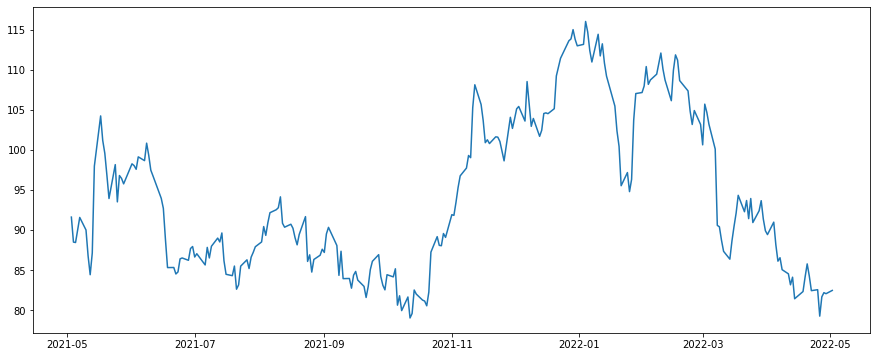

In [288]:
rcParams['figure.figsize'] = 15, 6 
plt.plot(ts_STX)

- 앞서 정리한 rolling_statistics함수를 이용하여 이동평균, 이동표준편차 시각화

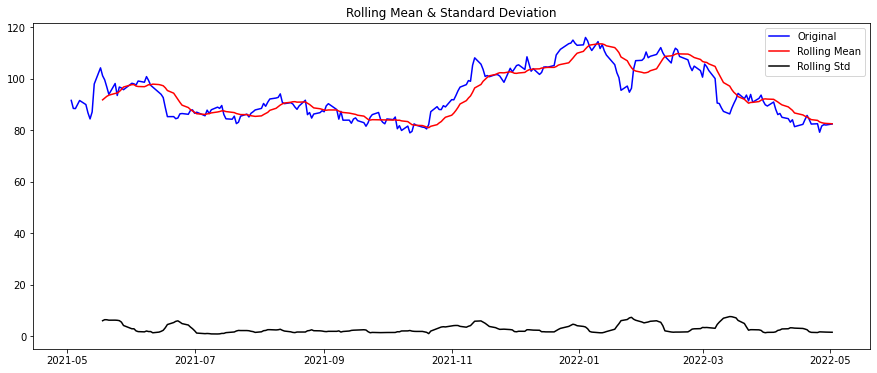

In [289]:
plot_rolling_statistics(ts_STX, window=12)

- 딱 봐도 이 시계열 데이터는 **stationary하지 않다**고 생각하지만, 계속 진행합니다.

In [290]:
augmented_dickey_fuller_test(ts_STX)

Results of Dickey-Fuller Test:
Test Statistic                  -1.683601
p-value                          0.439581
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- Augmented Dickey-Fuller Test로 확인해보니 ts_STX의 시계열이 안정적이지 않다는 귀무가설은 기각할 수 없으므로**(p-value의 값이 0에 가깝지 않아서)** 이 시계열은 안정적이라고 말할 수 없습니다.

#### 1.4.3 Stationary한 시계열로 가공

- Stationary한 시계열이 아니므로 가공을 진행해 줍니다.

##### 1) log함수 변환

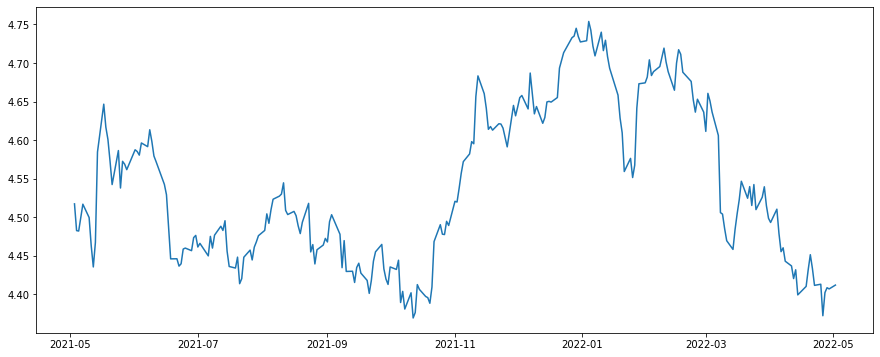

In [291]:
ts_log_STX = np.log(ts_STX)
plt.plot(ts_log_STX)

- 변화를 보기 위해 ADT Test로 다시 확인해봅니다.

In [292]:
augmented_dickey_fuller_test(ts_log_STX)

Results of Dickey-Fuller Test:
Test Statistic                  -1.691283
p-value                          0.435609
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 시간에 흐름에 따라 분산이 점점 커지는 경우에는 log함수로 변환해 주는 것이 도움이 될 수있으나 위 경우에는 큰 도움이 없었다고 판단할 수 있습니다.

- 아직도 p-value가 높으므로 stationary한 시계열로 만들기 위한 가공을 계속 진행합니다.

##### 2) Moving average 제거

- trend를 상쇄하기 위한 방법으로 방금 구한 log함수 값에서 MA(이동평균)을 빼줍니다.
- **MA는 5를 기준으로 제거**했습니다. 이유는 주가의 데이터가 Day이기 때문입니다.

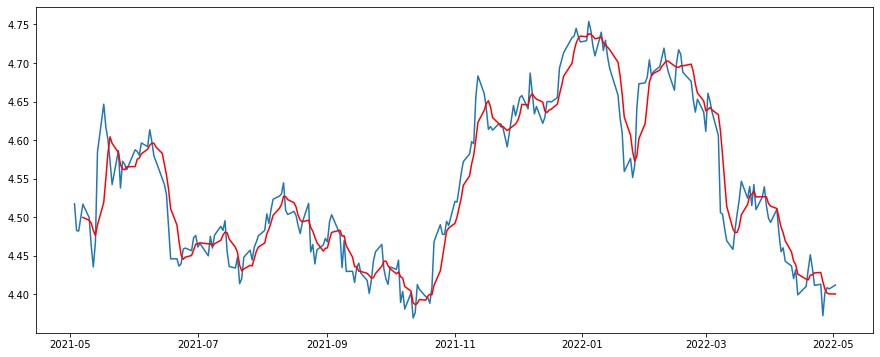

In [293]:
# moving average를 구해준다.
moving_avg_STX = ts_log_STX.rolling(window=5).mean()
plt.plot(ts_log_STX)
plt.plot(moving_avg_STX, color='red')

- MA값을 빼준 형태이므로 앞에 계산되지 않은 부분은 결측치로 남게됩니다. 

In [294]:
# ts_log 값에서 moving_avg 제거
ts_log_moving_avg_STX = ts_log_STX - moving_avg_STX
ts_log_moving_avg_STX.head(10)

Date
2021-05-03         NaN
2021-05-04         NaN
2021-05-05         NaN
2021-05-06         NaN
2021-05-07    0.017172
2021-05-10    0.003423
2021-05-11   -0.029204
2021-05-12   -0.047359
2021-05-13   -0.009184
2021-05-14    0.094543
Name: Close, dtype: float64

In [297]:
# moving average를 제거하면서 앞에 NaN값이 생기므로 정리한다.
ts_log_moving_avg_STX.dropna(inplace=True)
ts_log_moving_avg_STX.head(10)

Date
2021-05-07    0.017172
2021-05-10    0.003423
2021-05-11   -0.029204
2021-05-12   -0.047359
2021-05-13   -0.009184
2021-05-14    0.094543
2021-05-17    0.127101
2021-05-18    0.066572
2021-05-19    0.017515
2021-05-20   -0.031482
Name: Close, dtype: float64

- dropna를 활용해 잘 제거된 것으로 확인할 수 있습니다. 

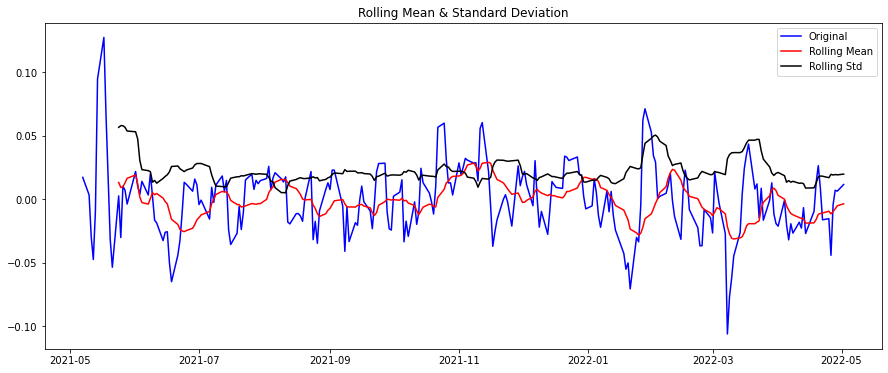

In [298]:
plot_rolling_statistics(ts_log_moving_avg_STX)

In [299]:
augmented_dickey_fuller_test(ts_log_moving_avg_STX)

Results of Dickey-Fuller Test:
Test Statistic                -8.047018e+00
p-value                        1.783276e-12
#Lags Used                     2.000000e+00
Number of Observations Used    2.460000e+02
Critical Value (1%)           -3.457215e+00
Critical Value (5%)           -2.873362e+00
Critical Value (10%)          -2.573070e+00
dtype: float64


- p-value 값이  0에 가깝다고 볼 수 있습니다.  
- log에 trend제거를 통해 이 시계열은 드디어 stationary하다고 볼 수 있습니다.

##### 3) 차분(Differencing), 계절성(Seasonality) 제거

- 사실 제 눈으로 봐서는 Seasonal한 변화가 있다고 보이지 않으나, 혹시 패턴이 파악되지 않은 주기적 변화가 있을 수 있기에 이런 부분을 제거하기 위해 differencing을 진행하고 seasonality를 제거해줍니다.

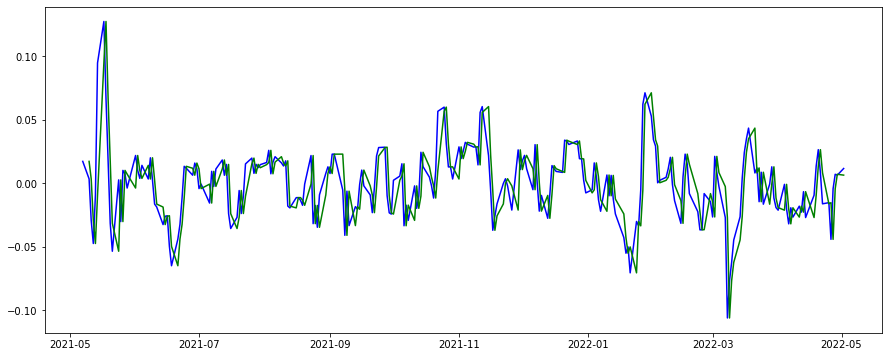

In [300]:
ts_log_moving_avg_shift_STX = ts_log_moving_avg_STX.shift()

plt.plot(ts_log_moving_avg_STX, color='blue')
plt.plot(ts_log_moving_avg_shift_STX, color='green')

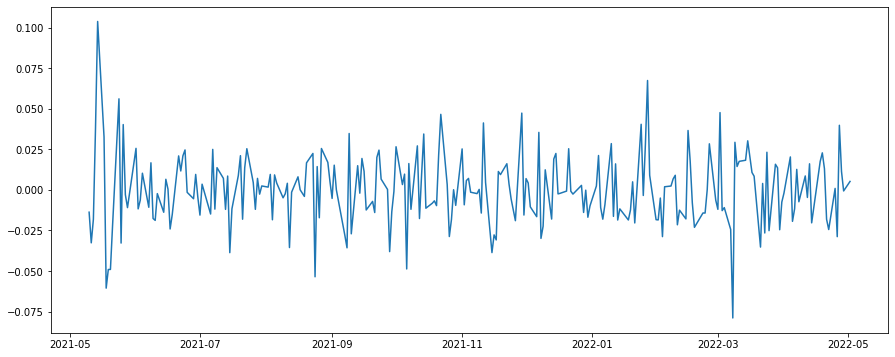

In [301]:
ts_log_moving_avg_diff_STX = ts_log_moving_avg_STX - ts_log_moving_avg_shift_STX
ts_log_moving_avg_diff_STX.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_STX)

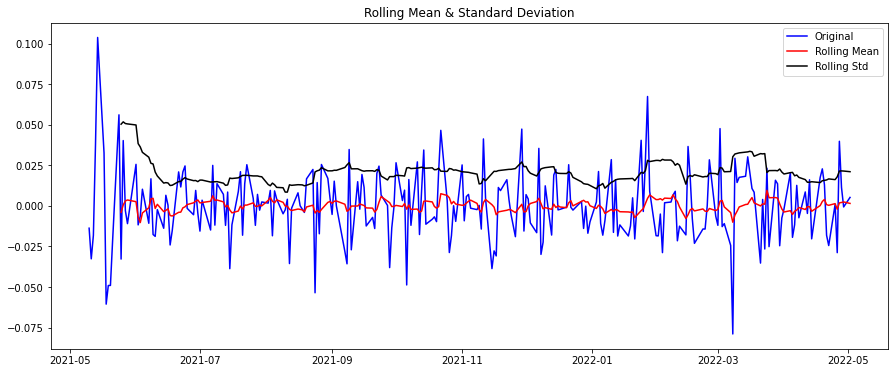

In [302]:
plot_rolling_statistics(ts_log_moving_avg_diff_STX)

- 차분을 해보니 이평과 표준편차가 기존 trend를 제거한 그래프에 비에 stationary 하다는 것을 알 수 있습니다.  
비교를 위해 아래 그래프를 같이 띄워봅니다.

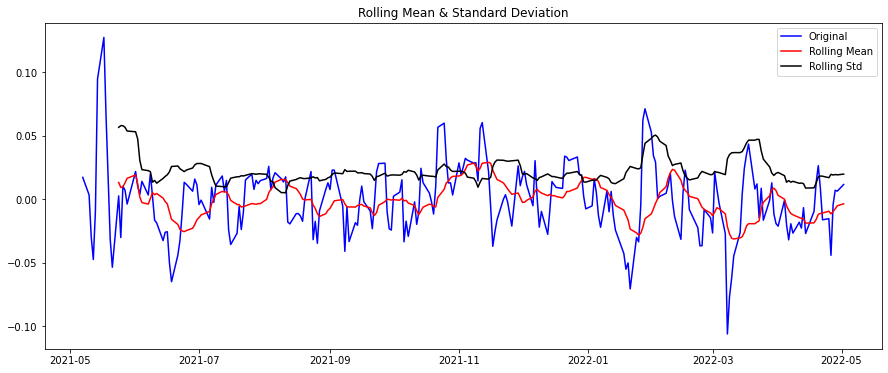

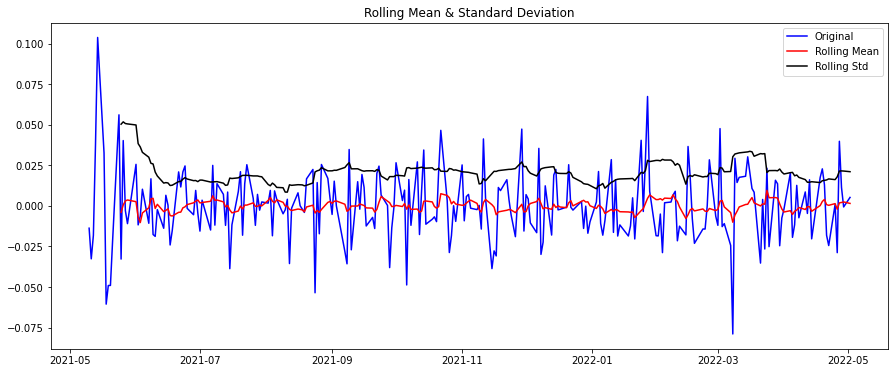

In [303]:
plot_rolling_statistics(ts_log_moving_avg_STX)
plot_rolling_statistics(ts_log_moving_avg_diff_STX)

- 두 그래프를 비교해보면 차분의 효과를 확실하게 확인할 수 있습니다.

- ADF Test로 p-value값도 다시 봅니다.

In [304]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_STX)

Results of Dickey-Fuller Test:
Test Statistic                -7.468622e+00
p-value                        5.124880e-11
#Lags Used                     1.100000e+01
Number of Observations Used    2.360000e+02
Critical Value (1%)           -3.458366e+00
Critical Value (5%)           -2.873866e+00
Critical Value (10%)          -2.573339e+00
dtype: float64


- 만족스럽습니다.

- 더 이상의 차분은 없습니다 그냥 진행합니다.

##### 4) 번외

- 이번에는 시계열 분해(Time series decomposition)를 진행합니다.

- 번외로 작성한 이유는 이미 log 변환, trend 제거, differencing을 통한 seasonality 제거를 진행했는데,   
라이브러리에 이미 귀찮고 번거로운 과정을 한 번에 수행해 줄 방법이 있기 때문입니다.   
공부하는 겸 원리를 파악하기 위해 하나하나 수행했지만, 저라면 seasonal_decompose를 쓰겠습니다!

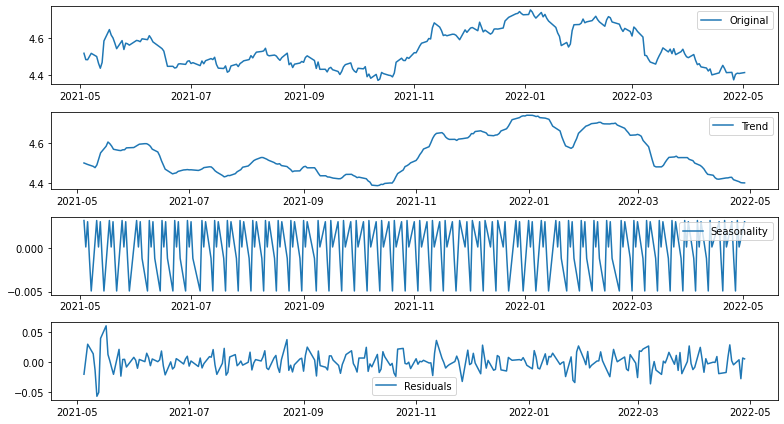

In [305]:
decomposition_STX = seasonal_decompose(ts_log_STX, model = 'additive', period = 5) # model = 'additive' / 'multiplicative' 선택 가능
trend_STX = decomposition_STX.trend
seasonal_STX = decomposition_STX.seasonal
residual_STX = decomposition_STX.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log_STX, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_STX, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_STX,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_STX, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

- trend 추세, seasonal는 계절성입니다. 
- residual은 잔차로 trend와 seasonality를 제거한 나머지 값으로 이를 통해 추가적으로 손 볼 부분이 있는지 확인할 수 있습니다. 
- model에는 'additive', 'multiplicative'옵션을 줄 수 있는데 주기적인 변화가 시간의 흐름에 따라 비례하게 발생하면 multiplicative 옵션을 이용하라고 합니다(seagate 주가의 흐름이 비례하게 multiple하지 않으니 additive 옵션을 줬습니다)
- 사실 제일 간단한건 둘 다 써보고 ADF Test 돌려보면 됩니다.



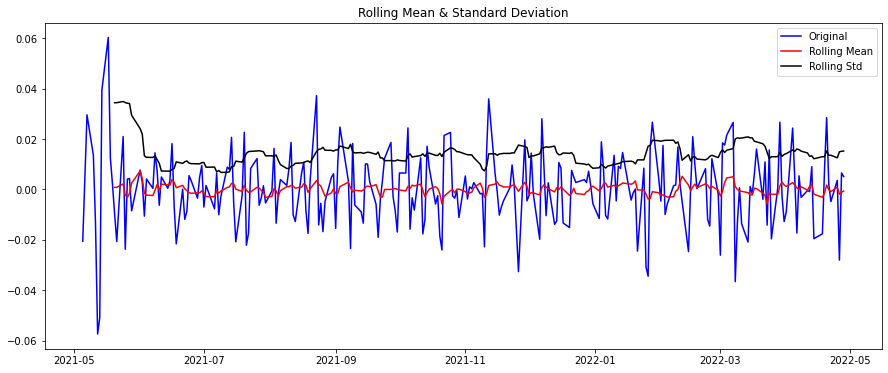

In [53]:
plot_rolling_statistics(residual_STX)

In [306]:
residual_STX.dropna(inplace=True)
augmented_dickey_fuller_test(residual_STX)

Results of Dickey-Fuller Test:
Test Statistic                  -5.393208
p-value                          0.000004
#Lags Used                      15.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


## 1.5 ARIMA 모델 활용

- ARIMA 모델을 활용하기 전에 재미있는 실험을 해보려합니다.
- 거의 모든 noise를 제거한 residual의 값을 이용해 구해보고, noise가 가득한 ts_log값을 이용해 구해봅니다.  
그리고 모델을 비교해봅니다.

#### 1.5.1 ARIMA 모델 모수 구하기

- 위에서 열심히 stationary한 시계열 데이터를 만든 이유가 여기에 있습니다.  
- ARIMA 모델을 추측해보건데 stationary한 시계열 데이터가 아니면 예측을 잘 못하나 봅니다.
- statsmodels의 acf 그래프와 pacf 그래프를 그려봅니다.


- 아래의 acf, pacf 그래프는 seasonal_decompose통해 얻은 잔차(residual) 값입니다.

1) ACF
- autocorrelation 즉 상관관계를 알아보자는 내용입니다. 더 공부를 해야겠지만 아는 한도내에서 그래프를 해석해봅니다.
- x축은 시차값입니다. 시간의 흐름에 따른 상관관계가 있는지를 판단할 수 있습니다.  
시간의 흐름, 즉 시차가 1 차이날 때 상관관계가 0에 급격하게 가까워집니다. 별 상관 없다는 뜻입니다.  
너무나 당연한 결과입니다. residual은 이미 trend와 seaonality를 최대한 제거했기 때문입니다.

2) PACF
 - PACF는 ACF가 모든 시계열 데이터의 특성을 분석하는 것에 한계가 있기에 추가적인 분석의 필요가 있을 때 사용됩니다. 시차가 다른 두 시계열 데이터 간의 상관관계를 구한다고 알고있습니다. 이 또한 큰 관련이 없다는걸 알 수 있습니다.

 - 둘다 lag 0값은 비교 대상이 자신인 값이므로 상관관계가 1에 수렴합니다. 급격하게 낮아지는 지점의 -1 값을 모수로 사용합니다.
 - p와 q 모두 lagged vaule 1 이후에 감소합니다.
 - **p = 0, q=0**

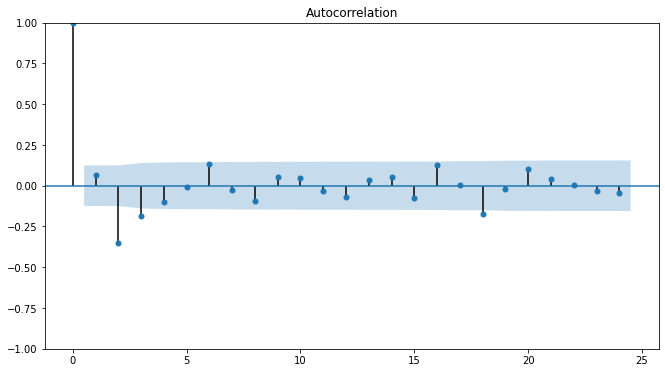

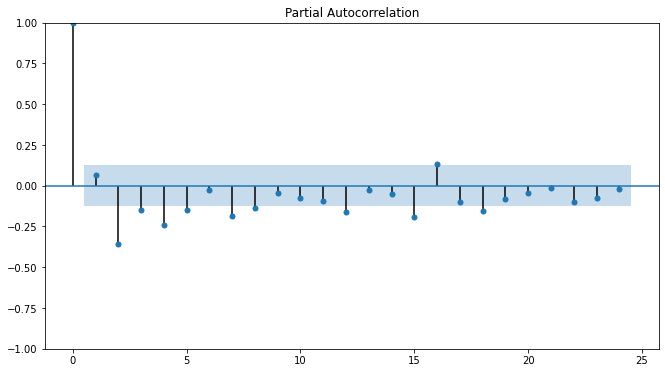

In [307]:
plot_acf(residual_STX)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(residual_STX)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 아래의 ACF, PACF 그래프는 기존 ts_STX 데이터를 log로 변환한 ts_log의 그래프입니다.
- 상단, 하단 ACF, PACF를 비교합니다.
- 아래 ts_log값은 trend, seasonality를 제거하지 않았습니다.  
당연히 시차간 상관관계가 강하게 있다고 볼 수 있습니다.  
PACF 그래프에서 상관관계가 적다고 판단할 수 있는 지점은 lag값이 3일 때입니다. 
- p = 1, q = 0

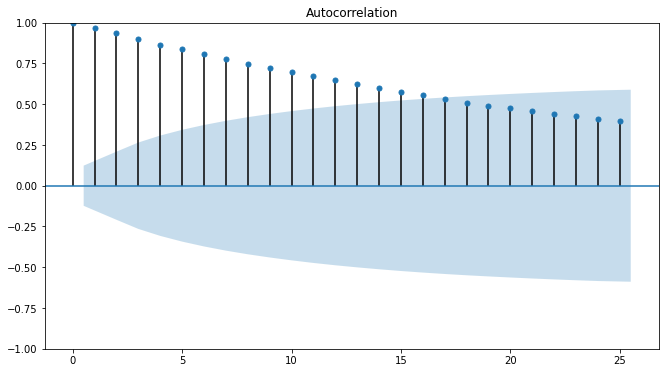

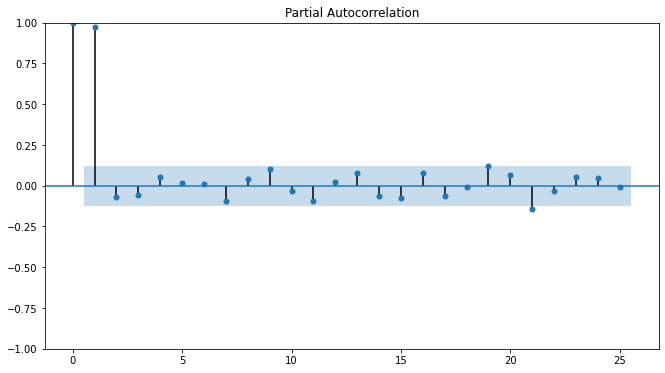

In [308]:
plot_acf(ts_log_STX)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_STX)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- d 값을 구하기 위해선 차분해보면 됩니다. ts_log는 stationary 하지 않습니다.  
differencing을 통해 stationary 한 횟수를 d 값으로 설정합니다.
- 1이면 충분해 보입니다. 
- d = 1

Results of Dickey-Fuller Test:
Test Statistic                -1.520394e+01
p-value                        5.777832e-28
#Lags Used                     0.000000e+00
Number of Observations Used    2.510000e+02
Critical Value (1%)           -3.456674e+00
Critical Value (5%)           -2.873125e+00
Critical Value (10%)          -2.572944e+00
dtype: float64


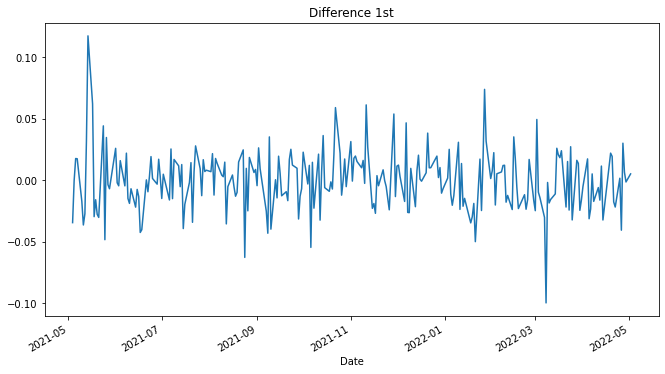

In [309]:
# 1차 차분 구하기
diff_1_STX = ts_log_STX.diff(periods=1).iloc[1:]
diff_1_STX.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_STX)

#### 1.5.2 ARIMA 모델 훈련

##### 1) residual를 이용한 ARIMA 모델학습

- train과 test 데이터로 나눠줍니다.

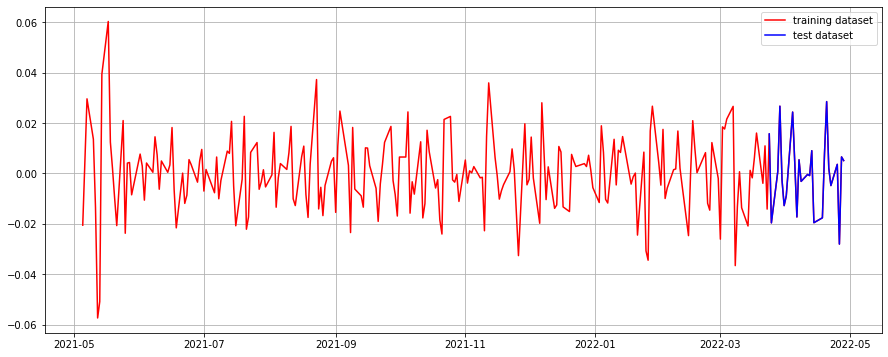

In [310]:
train_data_STX, test_data_STX = residual_STX[:int(len(residual_STX)*0.9)], residual[int(len(residual_STX)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(residual_STX, c='r', label='training dataset')
plt.plot(test_data_STX, c='b', label='test dataset')
plt.legend()

- p = 0, d = 0, q = 0

In [311]:
residual_model_STX = ARIMA(train_data_STX, order=(0, 0, 0))  
fitted_STX = residual_model_STX.fit() 

print(fitted_STX.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  224
Model:                          ARIMA   Log Likelihood                 623.417
Date:                Thu, 05 May 2022   AIC                          -1242.835
Time:                        09:43:46   BIC                          -1236.011
Sample:                             0   HQIC                         -1240.080
                                - 224                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const       -4.34e-05      0.001     -0.043      0.965      -0.002       0.002
sigma2         0.0002   1.54e-05     14.569      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.77   Jarque-

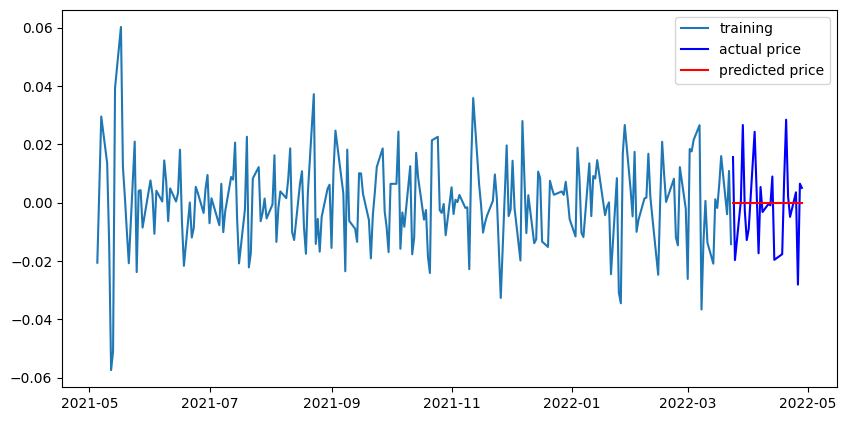

In [312]:
# Forecast : 결과가 fc_STX에 담깁니다. 
fc_STX = fitted_STX.forecast(len(test_data_STX), alpha=0.05)  # 95% conf
fc_STX = np.array(fc_STX)
# Make as pandas series
fc_series_STX = pd.Series(fc_STX, index=test_data_STX.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_STX, label='training')
plt.plot(test_data_STX, c='b', label='actual price')
plt.plot(fc_series_STX, c='r',label='predicted price')
plt.legend()
plt.show()

In [313]:
mse = mean_squared_error(np.exp(test_data_STX), np.exp(fc_STX))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_STX), np.exp(fc_STX))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_STX), np.exp(fc_STX)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_STX) - np.exp(test_data_STX))/np.abs(np.exp(test_data_STX)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  0.00020407220391774317
MAE:  0.011031136052950394
RMSE:  0.014285384276166433
MAPE: 1.10%


- 예측이란 부분이 의미가 없어보입니다. 시계열 데이터 자체가 여러 처리과정을 거치며 백색잡음만 남았기 때문이라고 생각합니다. 자기상관값이 정확하게 0은 아니지만 거의 0이기 때문입니다.
- MAPE가 0%에 가깝지만, 주가 예측은 실패입니다.

##### 2) log변환을 이용한 ARIMA 모델학습

- 자 다음 noise가 잔뜩 낀 ts_log 모델입니다.
- 절차는 residual을 사용할 때와 동일하므로 바로 진행합니다.

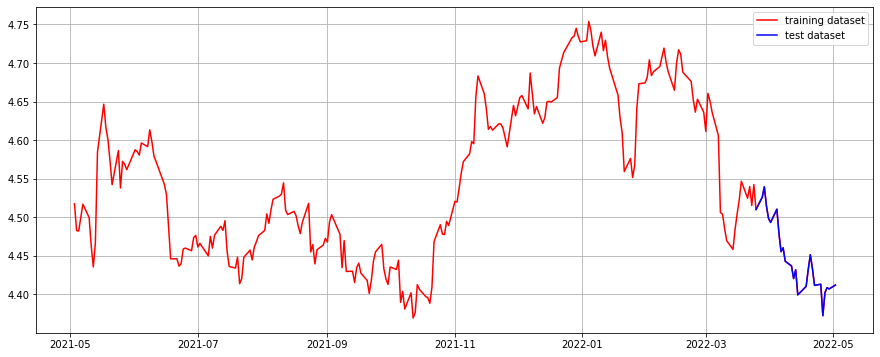

In [314]:
train_log_data_STX, test_log_data_STX = ts_log_STX[:int(len(ts_log_STX)*0.9)], ts_log[int(len(ts_log_STX)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log_STX, c='r', label='training dataset')
plt.plot(test_log_data_STX, c='b', label='test dataset')
plt.legend()

- p = 17, d = 1, q = 1
- p값은 임의로 지정하고 수정하면서 MAPE를 확인합니다.
- d와 q는 위에서 구해준 값을 사용합니다.

In [315]:
ts_log_model_STX = ARIMA(train_log_data_STX, order=(17, 1, 1))  
fitted_log_STX = ts_log_model_STX.fit() 

print(fitted_log_STX.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                ARIMA(17, 1, 1)   Log Likelihood                 523.296
Date:                Thu, 05 May 2022   AIC                          -1008.593
Time:                        09:46:32   BIC                           -943.603
Sample:                             0   HQIC                          -982.365
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0195      8.369      0.002      0.998     -16.383      16.421
ar.L2          0.0772      0.526      0.147      0.883      -0.954       1.109
ar.L3         -0.0772      0.612     -0.126      0.9

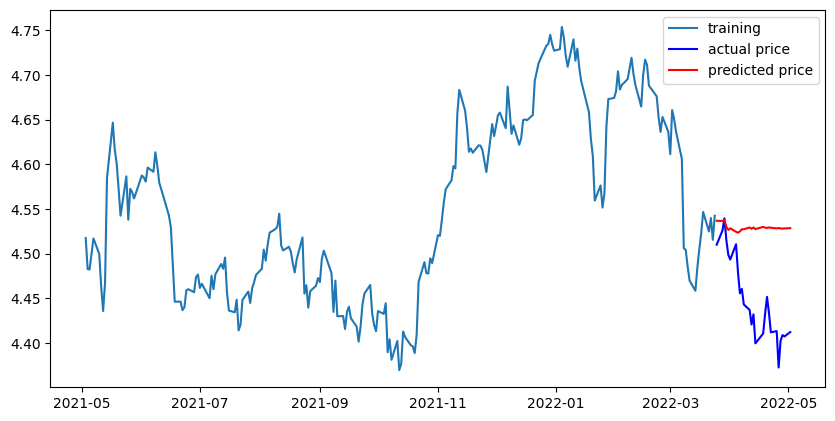

In [316]:
# Forecast : 결과가 fc_log_STX에 담깁니다. 
fc_log_STX = fitted_log_STX.forecast(len(test_log_data_STX), alpha=0.05)  # 95% conf
fc_log_STX = np.array(fc_log_STX)
# Make as pandas series
fc_log_series_STX = pd.Series(fc_log_STX, index=test_log_data_STX.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_log_data_STX, label='training')
plt.plot(test_log_data_STX, c='b', label='actual price')
plt.plot(fc_log_series_STX, c='r',label='predicted price')
plt.legend()
plt.show()

#### 1.5.3 ARIMA 모델 결과 해석

- predicted price를 어떻게 보시나요?  
  전 예측을 잘했다기 보다는 seagate라는 회사의 주가를 stational한 상태로 만들어 놓았다고 생각합니다.   
  '너의 확률적 특성은 저 지점이야 시간이 지나면 여기로 회귀할 거야!'라는 답정너스러운 결과로 보입니다.

- 그래도 이번 주제는 예측이니까 예측의 측면에서 바라본다면 ARIMA는 정말 seasonal하거나 trendy한 데이터에 noise를 제거하고 돌린다면 잘 예측할 것 같다. 하지만 주가와 같은 데이터는 다른 모델을 사용하는 것을 고려해봐야 합니다. 
  

- 특히 ARIMA는 종속변수만 가지고 예측을 합니다. 다양한 feature들이 작용하는 시장에서 활용하는 것은 무의미하다고 생각합니다.

In [317]:
mse = mean_squared_error(np.exp(test_log_data_STX), np.exp(fc_log_STX))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_log_data_STX), np.exp(fc_log_STX))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_log_data_STX), np.exp(fc_log_STX)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_log_STX) - np.exp(test_log_data_STX))/np.abs(np.exp(test_log_data_STX)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  63.60850239025646
MAE:  7.036795224702766
RMSE:  7.975493864975163
MAPE: 8.43%


 - MAPE값

- MAPE(mean absolute percentage error)는 퍼센트 값을 가지며 0에 가까울수록 회귀 모형의 성능이 좋다고 해석할 수 있습니다. 
- MSE로는 모형의 좋고 나쁨을 비교하여 판단하기 어렵기에 MAPE 퍼센트 값을 통해 성능을 평가해줍니다.

- 적절한 p 값을 찾는 것도 중요합니다. ACF 그래프에서 상관관계가 없어지는 lagged value 값을 찾지 못해서 임의의 p값을 두고 계산했습니다(p값이 높다고 예측을 잘 하는 것이 아닙니다)
- p가 높을수록 predicted price 값이 그럴싸하게 보이기만하지 메모리는 더 많이 먹습니다.  
클라우드 커널에서 돌리면 커널이 죽습니다...

(50,1,1) : 11.42%  
(20,1,1) : 9.63%  
(18,1,1) : 10.50%  
(17,1,1) :   8.43%  
(16,1,1) :   8.52%  
(15,1,1) : 9.14%  
(14,1,1) :   8.62%  
(12,1,1) : 9.31%   
(8,1,1) : 9.25%  
(5,1,1) : 10.10%    
(1,1,1) : 10.09%

## **2. 주가 예측(ARKF)**

- ARKF : Ark Fintech Innovation ETF(Ark의 핀테크 ETF)
- 돈나무 누나(Catherine D. Wood)로 유명한 그 회사에서 운용하는 ETF 입니다.

### 2.1 모듈 설정(생략)

- 이미 설정했으므로 생략합니다.

### 2.2 함수 정리(생략)

- 이미 설정했으므로 생략합니다.

### 2.3 데이터 로드(생략)

- 이미 로드했으므로 생략합니다.

### 2.4 ARKF

#### 2.4.1 데이터 확인

In [113]:
# df_ARKF 데이터에서 종가('Close')만 따로 series 형태로 분리한다. 
print(type(df_ARKF))
print(df_ARKF.head(5))

ts_ARKF = df_ARKF['Close']
print(type(ts_ARKF))
print(ts_ARKF.head(5))

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-04  50.779999  50.830002  49.150002  50.200001  50.200001  2545200
2021-05-05  50.639999  50.840000  49.520000  49.799999  49.799999  1364200
2021-05-06  49.599998  49.618999  48.130001  48.810001  48.810001  2334000
2021-05-07  49.529999  50.189999  49.099998  49.410000  49.410000  1501100
2021-05-10  48.730000  48.900002  46.950001  47.020000  47.020000  2754300
<class 'pandas.core.series.Series'>
Date
2021-05-04    50.200001
2021-05-05    49.799999
2021-05-06    48.810001
2021-05-07    49.410000
2021-05-10    47.020000
Name: Close, dtype: float64


#### 2.4.2 시각화

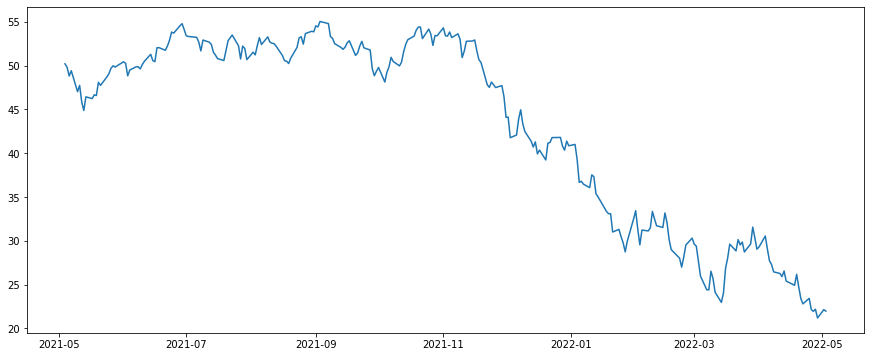

In [114]:
rcParams['figure.figsize'] = 15, 6 
plt.plot(ts_ARKF)

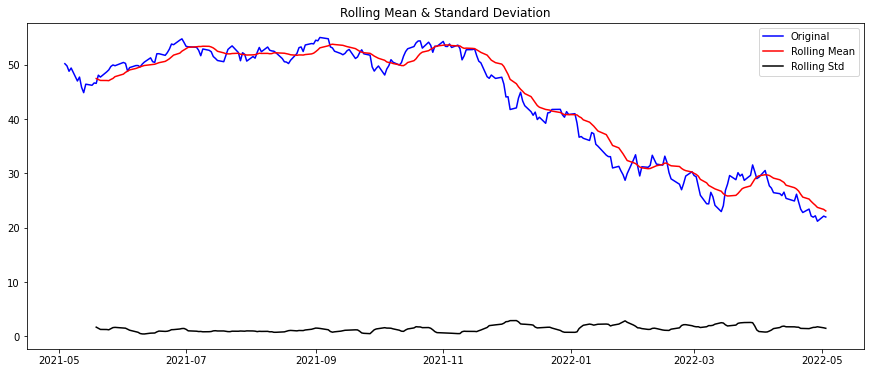

In [115]:
plot_rolling_statistics(ts_ARKF, window=12)

- 2021년 11월을 기점으로 우하향합니다.  
 패턴이 보이는 것 같습니다.

#### 2.4.3 Stationary한 시계열로 가공

##### 1) log함수 변환

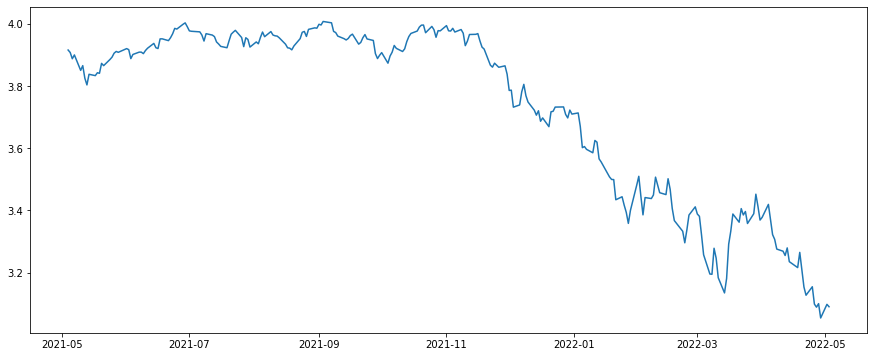

In [116]:
ts_log_ARKF = np.log(ts_ARKF)
plt.plot(ts_log_ARKF)

##### 2) Moving average 제거

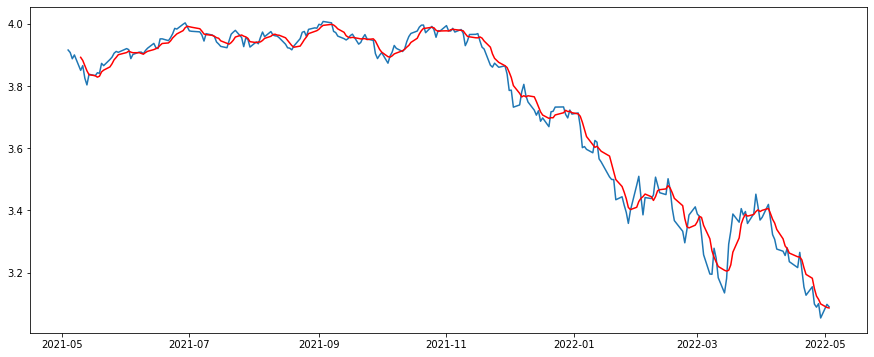

In [117]:
# moving average를 구해준다.
moving_avg_ARKF = ts_log_ARKF.rolling(window=5).mean()
plt.plot(ts_log_ARKF)
plt.plot(moving_avg_ARKF, color='red')

In [118]:
# ts_log 값에서 moving_avg 제거
ts_log_moving_avg_ARKF = ts_log_ARKF - moving_avg_ARKF
ts_log_moving_avg_ARKF.head(10)

Date
2021-05-04         NaN
2021-05-05         NaN
2021-05-06         NaN
2021-05-07         NaN
2021-05-10   -0.041965
2021-05-11   -0.016719
2021-05-12   -0.040586
2021-05-13   -0.045359
2021-05-14    0.001259
2021-05-17    0.000331
Name: Close, dtype: float64

In [119]:
# moving average를 제거하면서 앞에 NaN값이 생기므로 정리한다.
ts_log_moving_avg_ARKF.dropna(inplace=True)
ts_log_moving_avg_ARKF.head(10)

Date
2021-05-10   -0.041965
2021-05-11   -0.016719
2021-05-12   -0.040586
2021-05-13   -0.045359
2021-05-14    0.001259
2021-05-17    0.000331
2021-05-18    0.014166
2021-05-19    0.009291
2021-05-20    0.027333
2021-05-21    0.014463
Name: Close, dtype: float64

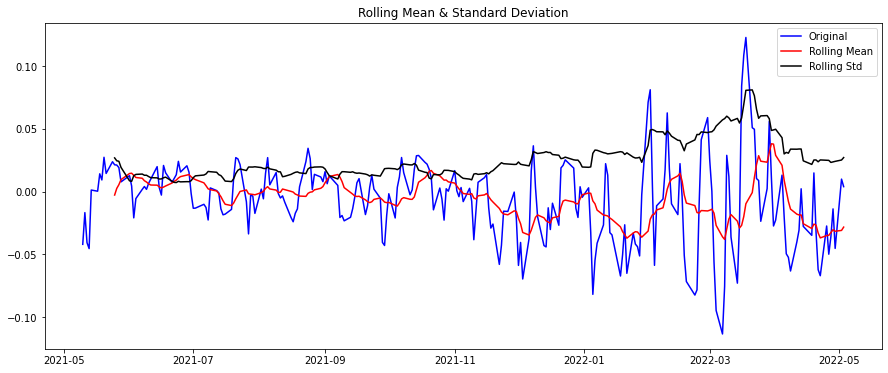

In [120]:
plot_rolling_statistics(ts_log_moving_avg_ARKF)

In [121]:
augmented_dickey_fuller_test(ts_log_moving_avg_ARKF)

Results of Dickey-Fuller Test:
Test Statistic                  -3.952776
p-value                          0.001679
#Lags Used                      15.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


- p-value 값이 충분히 작지만 더 진행해봅니다.

##### 3) 차분(Differencing), 계절성(Seasonality) 제거

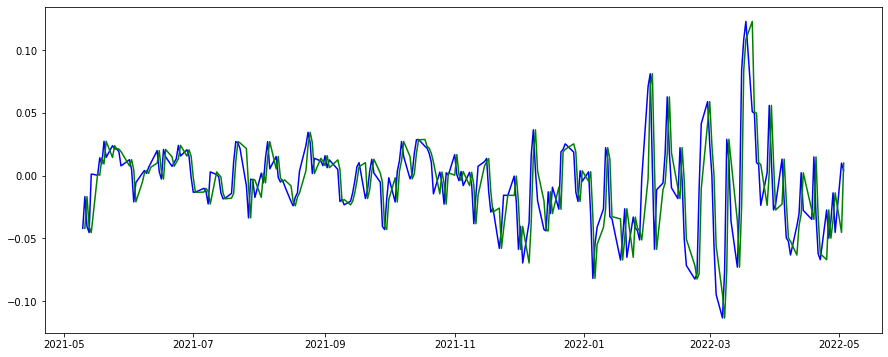

In [122]:
ts_log_moving_avg_shift_ARKF = ts_log_moving_avg_ARKF.shift()

plt.plot(ts_log_moving_avg_ARKF, color='blue')
plt.plot(ts_log_moving_avg_shift_ARKF, color='green')

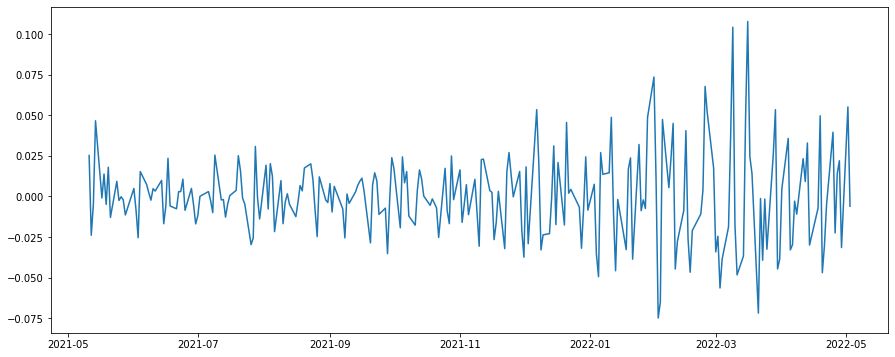

In [123]:
ts_log_moving_avg_diff_ARKF = ts_log_moving_avg_ARKF - ts_log_moving_avg_shift_ARKF
ts_log_moving_avg_diff_ARKF.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_ARKF)

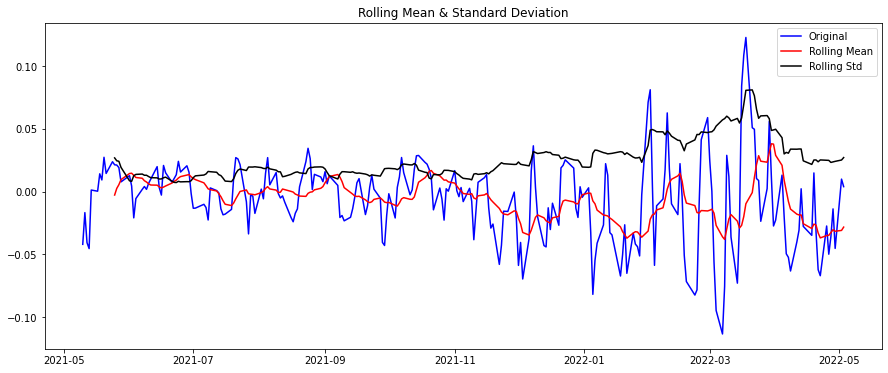

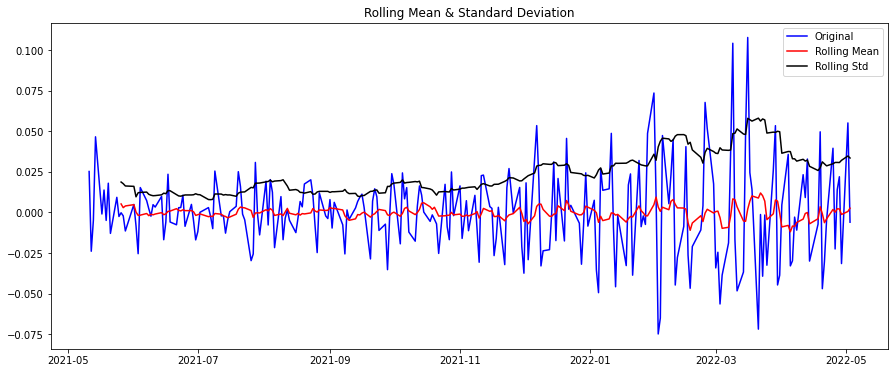

In [125]:
plot_rolling_statistics(ts_log_moving_avg_ARKF)
plot_rolling_statistics(ts_log_moving_avg_diff_ARKF)

In [126]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_ARKF)

Results of Dickey-Fuller Test:
Test Statistic                -5.693264e+00
p-value                        7.980592e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.330000e+02
Critical Value (1%)           -3.458731e+00
Critical Value (5%)           -2.874026e+00
Critical Value (10%)          -2.573424e+00
dtype: float64


- differencing을 통해 충분히 만족할 수준까지 떨어진 것 같습니다.

##### 4) seasonal_decompose

- model 옵션은 additive이 적합합니다.  
additive를 선택한 이유는... 둘 다 해봤습니다.

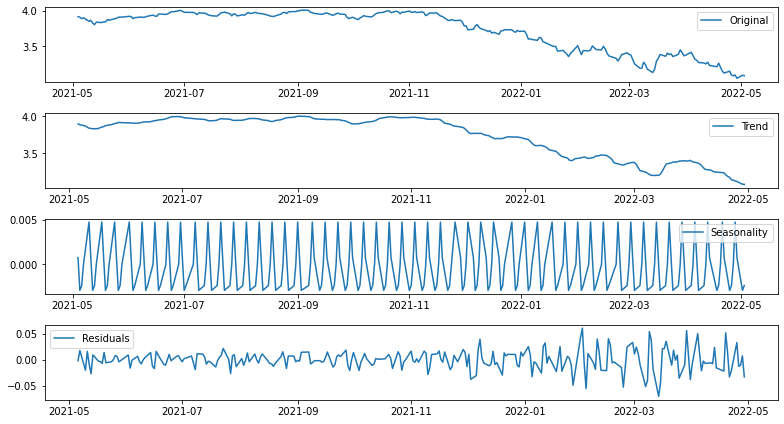

In [180]:
decomposition_ARKF = seasonal_decompose(ts_log_ARKF, model = 'additive', period = 5) # model = 'additive' / 'multiplicative' 선택 가능
trend_ARKF = decomposition_ARKF.trend
seasonal_ARKF = decomposition_ARKF.seasonal
residual_ARKF = decomposition_ARKF.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log_ARKF, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_ARKF, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_ARKF,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_ARKF, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

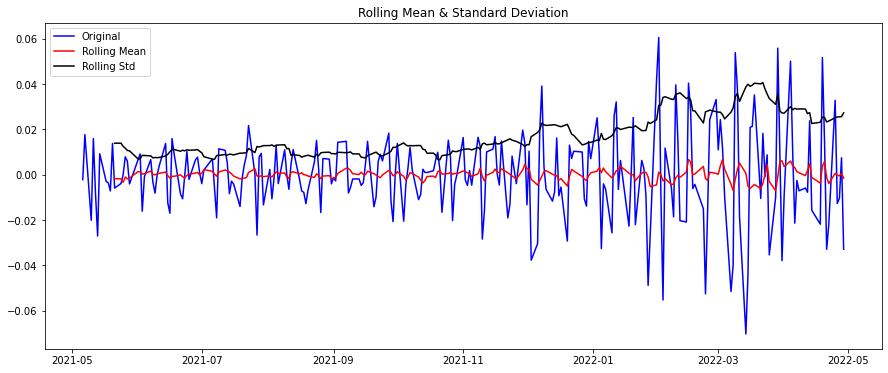

In [181]:
plot_rolling_statistics(residual_ARKF)

In [182]:
residual_ARKF.dropna(inplace=True)
augmented_dickey_fuller_test(residual_ARKF)

Results of Dickey-Fuller Test:
Test Statistic                -6.041412e+00
p-value                        1.343204e-07
#Lags Used                     1.400000e+01
Number of Observations Used    2.340000e+02
Critical Value (1%)           -3.458608e+00
Critical Value (5%)           -2.873972e+00
Critical Value (10%)          -2.573396e+00
dtype: float64


- 직접 differencing을 진행했던 이평, 표준편차 보단 덜 하지만 충분히 stationary하다고 생각합니다.

## 2.5 ARIMA 모델 활용

#### 2.5.1 ARIMA 모델 모수 구하기

- 위에선 학습차원에서 residual과 time series의 log값 둘 다 진행했지만, 이번에는 log로만 진행합니다.

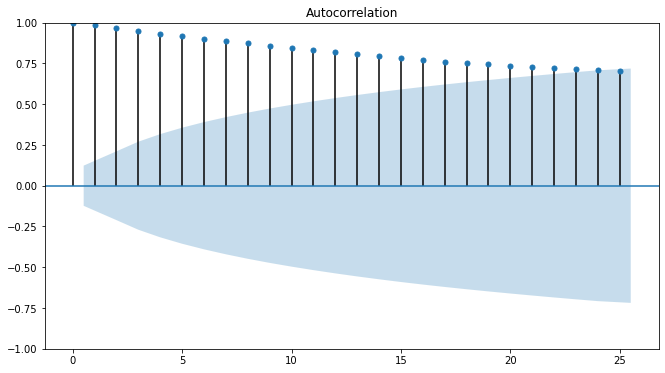

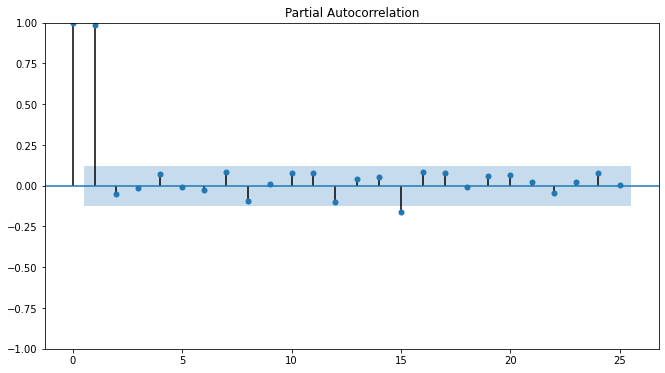

In [132]:
plot_acf(ts_log_ARKF)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_ARKF)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- ACF, PACF 그래프를 참고하여 p값은 임의로 부여하고, q는 1을 설정하겠습니다.

Results of Dickey-Fuller Test:
Test Statistic                  -3.966714
p-value                          0.001595
#Lags Used                      14.000000
Number of Observations Used    237.000000
Critical Value (1%)             -3.458247
Critical Value (5%)             -2.873814
Critical Value (10%)            -2.573311
dtype: float64


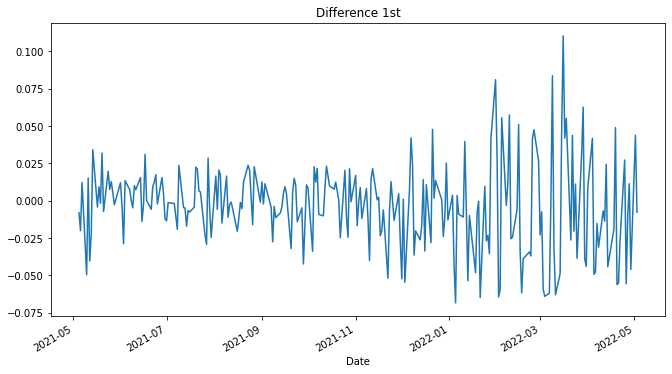

In [133]:
# 1차 차분 구하기
diff__ARKF_1 = ts_log_ARKF.diff(periods=1).iloc[1:]
diff__ARKF_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff__ARKF_1)

- 차분을 더 진행합니다.

Results of Dickey-Fuller Test:
Test Statistic                -6.487023e+00
p-value                        1.253518e-08
#Lags Used                     1.300000e+01
Number of Observations Used    2.370000e+02
Critical Value (1%)           -3.458247e+00
Critical Value (5%)           -2.873814e+00
Critical Value (10%)          -2.573311e+00
dtype: float64


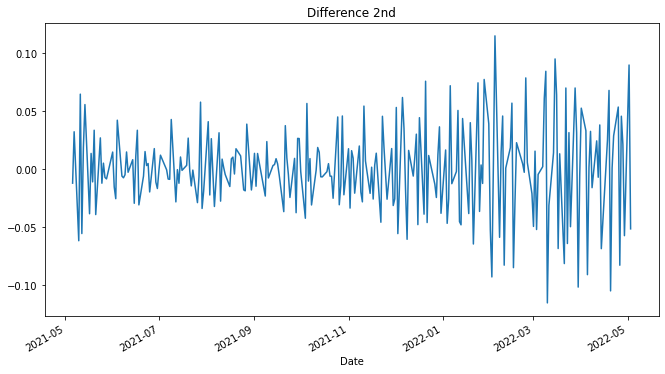

In [134]:
# 2차 차분 구하기
diff__ARKF_2 = diff__ARKF_1.diff(periods=1).iloc[1:]
diff__ARKF_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff__ARKF_2)

- 충분하니 그만합니다.
- **d = 2**

#### 2.5.2 ARIMA 모델 훈련

##### 1) log변환을 이용한 ARIMA 모델학습

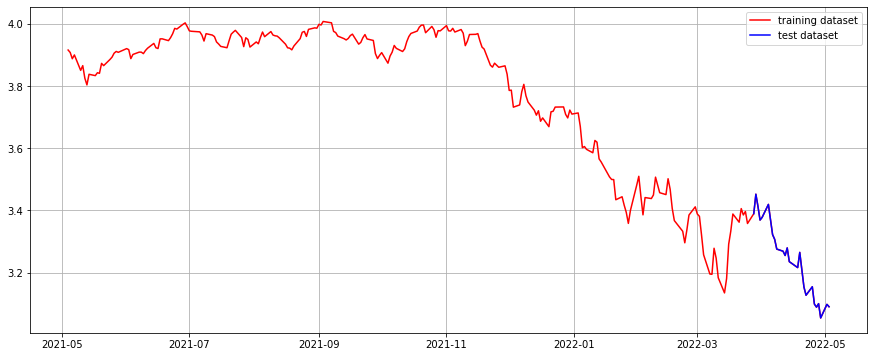

In [135]:
train_data_ARKF, test_data_ARKF = ts_log_ARKF[:int(len(ts_log)*0.9)], ts_log_ARKF[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log_ARKF, c='r', label='training dataset')
plt.plot(test_data_ARKF, c='b', label='test dataset')
plt.legend()

In [152]:
model_ARKF = ARIMA(train_data_ARKF, order=(1, 2, 1))  
fitted_ARKF = model_ARKF.fit() 

print(fitted_ARKF.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(1, 2, 1)   Log Likelihood                 490.609
Date:                Thu, 05 May 2022   AIC                           -975.219
Time:                        08:48:07   BIC                           -964.970
Sample:                             0   HQIC                          -971.082
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1638      0.055      2.997      0.003       0.057       0.271
ma.L1         -0.9952      0.016    -63.332      0.000      -1.026      -0.964
sigma2         0.0007   6.47e-05     11.331      0.0

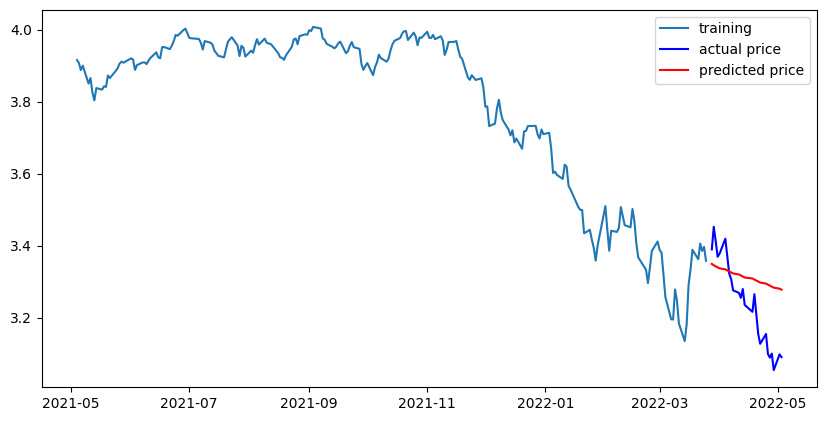

In [153]:
# Forecast : 결과가 fc_log_ARKF에 담깁니다. 
fc_log_ARKF = fitted_ARKF.forecast(len(test_data_ARKF), alpha=0.05)  # 95% conf
fc_log_ARKF = np.array(fc_log_ARKF)
# Make as pandas series
fc_log_ARKF_series = pd.Series(fc_log_ARKF, index=test_data_ARKF.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_ARKF, label='training')
plt.plot(test_data_ARKF, c='b', label='actual price')
plt.plot(fc_log_ARKF_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 2.5.3 ARIMA 모델 결과 해석

In [154]:
mse = mean_squared_error(np.exp(test_data_ARKF), np.exp(fc_log_ARKF))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_ARKF), np.exp(fc_log_ARKF))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_ARKF), np.exp(fc_log_ARKF)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_log_ARKF) - np.exp(test_data_ARKF))/np.abs(np.exp(test_data_ARKF)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  8.862267785358565
MAE:  2.536681838589037
RMSE:  2.97695612755018
MAPE: 10.52%


- 15부터 1까지 내려오며 p값을 수정했습니다. 그나마 제일 좋은 결과는 p값이 1일 때 10.52%로 약 10~30% 사이에서 움직입니다.  
아무리 봐도 평균값에 수렴하려는 성질이 강한 것 같습니다.


## **3. 주가 예측(ARKG)**

- ARKG : ARK Genomic Revolution ETF(Ark의 유전 기술 관련 ETF)

### 3.1 모듈 설정(생략)

- 이미 설정했으므로 생략합니다.

### 3.2 함수 정리(생략)

- 이미 설정했으므로 생략합니다.

### 3.3 데이터 로드(생략)

- 이미 로드했으므로 생략합니다.

### 3.4 ARKG

#### 3.4.1 데이터 확인

In [155]:
# df_ARKG 데이터에서 종가('Close')만 따로 series 형태로 분리한다. 
print(type(df_ARKG))
print(df_ARKG.head(5))

ts_ARKG = df_ARKG['Close']
print(type(ts_ARKG))
print(ts_ARKG.head(5))

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-04  85.029999  85.180000  82.239998  83.419998  82.897255  4958400
2021-05-05  83.820000  84.278000  81.570000  82.089996  81.575584  3157400
2021-05-06  81.209999  81.400002  78.199997  79.839996  79.339684  6115400
2021-05-07  80.900002  83.059998  80.430000  80.870003  80.363235  3643300
2021-05-10  80.440002  80.449997  76.099998  76.129997  75.652939  7324500
<class 'pandas.core.series.Series'>
Date
2021-05-04    83.419998
2021-05-05    82.089996
2021-05-06    79.839996
2021-05-07    80.870003
2021-05-10    76.129997
Name: Close, dtype: float64


#### 3.4.2 시각화

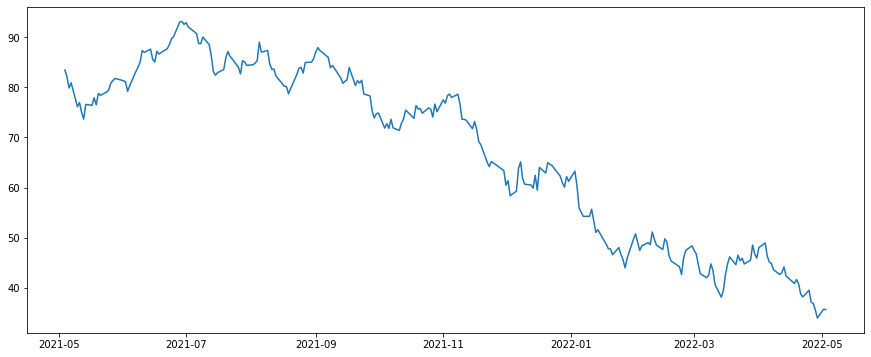

In [156]:
rcParams['figure.figsize'] = 15, 6 
plt.plot(ts_ARKG)

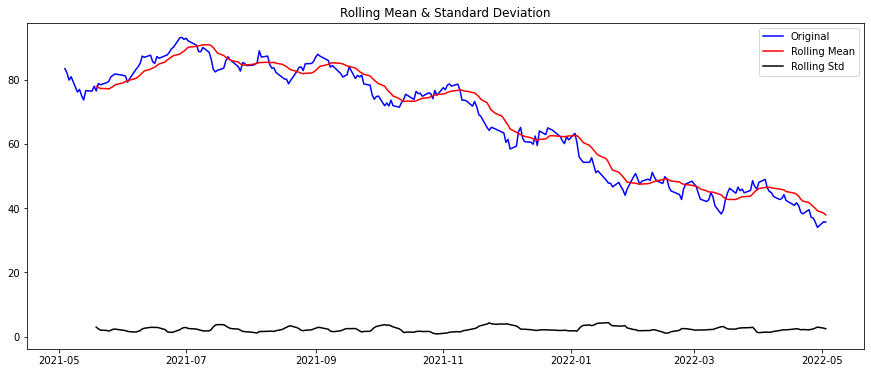

In [157]:
plot_rolling_statistics(ts_ARKG, window=12)

- 이 ETF는 ARKF보다 더 패턴이 잘 보입니다 2021년 07월부터 꾸준한 우하향입니다.

#### 3.4.3 Stationary한 시계열로 가공

##### 1) log함수 변환

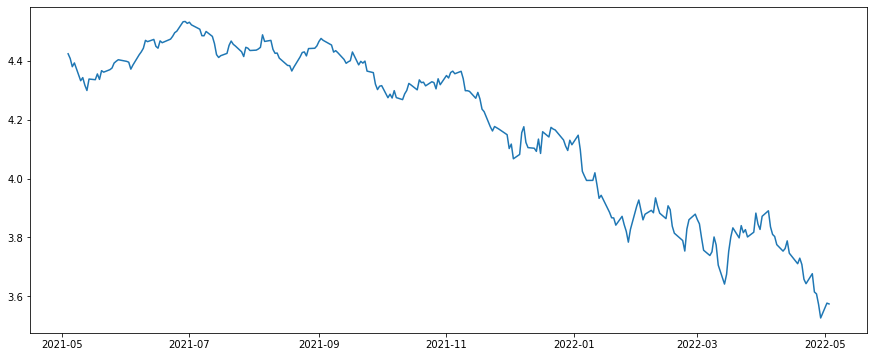

In [158]:
ts_log_ARKG = np.log(ts_ARKG)
plt.plot(ts_log_ARKG)

##### 2) Moving average 제거

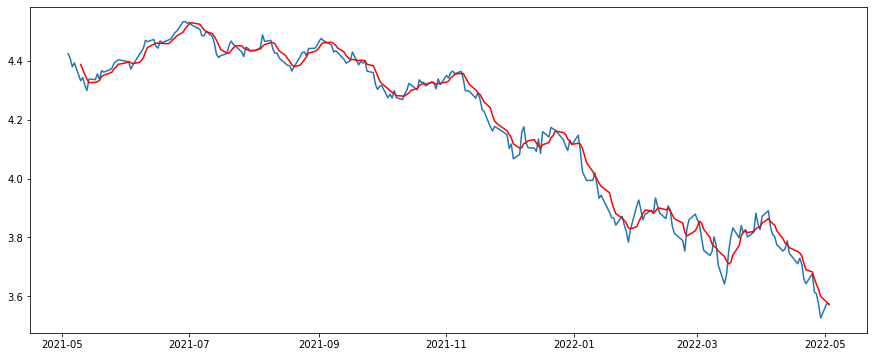

In [159]:
# moving average를 구해준다.
moving_avg_ARKG = ts_log_ARKG.rolling(window=5).mean()
plt.plot(ts_log_ARKG)
plt.plot(moving_avg_ARKG, color='red')

In [160]:
# ts_log 값에서 moving_avg 제거
ts_log_moving_avg_ARKG = ts_log_ARKG - moving_avg_ARKG
ts_log_moving_avg_ARKG.head(10)

Date
2021-05-04         NaN
2021-05-05         NaN
2021-05-06         NaN
2021-05-07         NaN
2021-05-10   -0.054960
2021-05-11   -0.028308
2021-05-12   -0.035757
2021-05-13   -0.037757
2021-05-14    0.012084
2021-05-17    0.009179
Name: Close, dtype: float64

In [161]:
# moving average를 제거하면서 앞에 NaN값이 생기므로 정리한다.
ts_log_moving_avg_ARKG.dropna(inplace=True)
ts_log_moving_avg_ARKG.head(10)

Date
2021-05-10   -0.054960
2021-05-11   -0.028308
2021-05-12   -0.035757
2021-05-13   -0.037757
2021-05-14    0.012084
2021-05-17    0.009179
2021-05-18    0.026247
2021-05-19    0.003811
2021-05-20    0.019976
2021-05-21    0.010211
Name: Close, dtype: float64

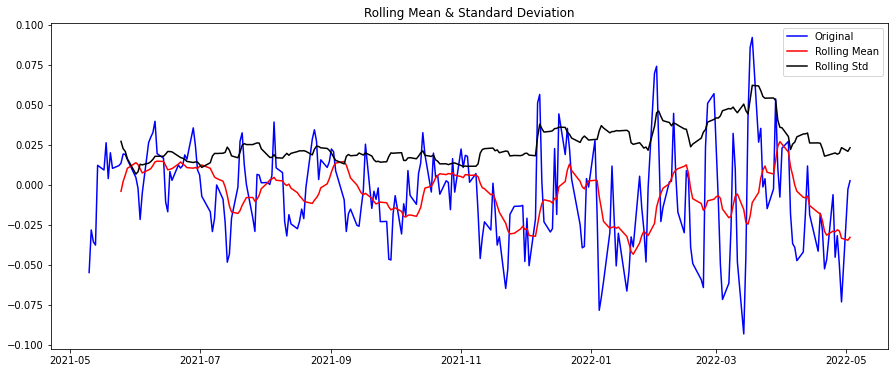

In [162]:
plot_rolling_statistics(ts_log_moving_avg_ARKG)

In [163]:
augmented_dickey_fuller_test(ts_log_moving_avg_ARKG)

Results of Dickey-Fuller Test:
Test Statistic                  -5.091259
p-value                          0.000015
#Lags Used                       4.000000
Number of Observations Used    244.000000
Critical Value (1%)             -3.457438
Critical Value (5%)             -2.873459
Critical Value (10%)            -2.573122
dtype: float64


- 이정도면 p-value값이 0에 수렴하는 수준이라고 봐도 좋을 것 같습니다 이대로 이용하고 싶습니다만, differencing을 진행합니다.

##### 3) 차분(Differencing), 계절성(Seasonality) 제거

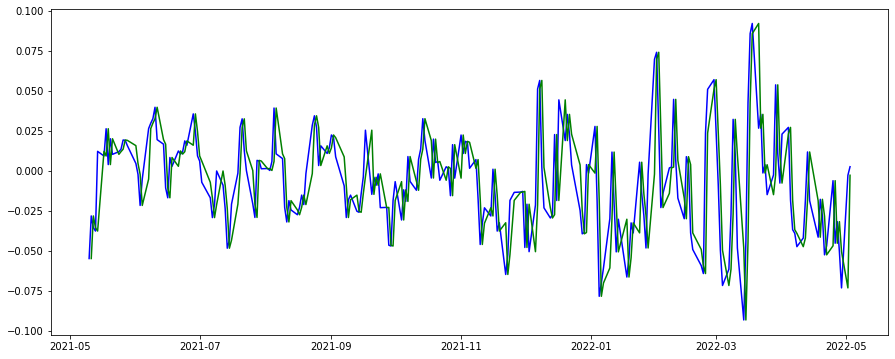

In [164]:
ts_log_moving_avg_shift_ARKG = ts_log_moving_avg_ARKG.shift()

plt.plot(ts_log_moving_avg_ARKG, color='blue')
plt.plot(ts_log_moving_avg_shift_ARKG, color='green')

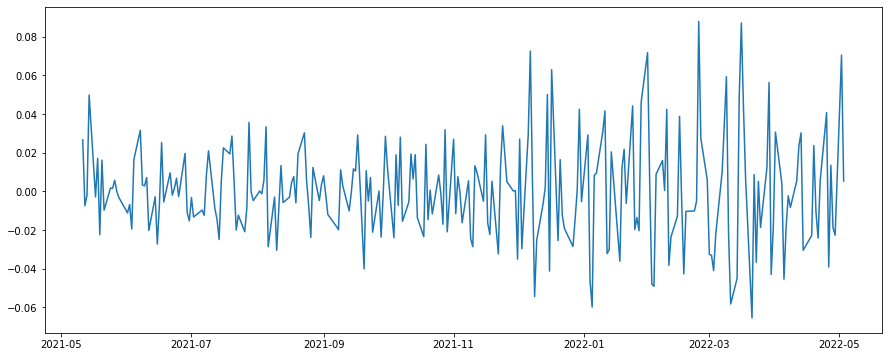

In [165]:
ts_log_moving_avg_diff_ARKG = ts_log_moving_avg_ARKG - ts_log_moving_avg_shift_ARKG
ts_log_moving_avg_diff_ARKG.dropna(inplace=True)
plt.plot(ts_log_moving_avg_diff_ARKG)

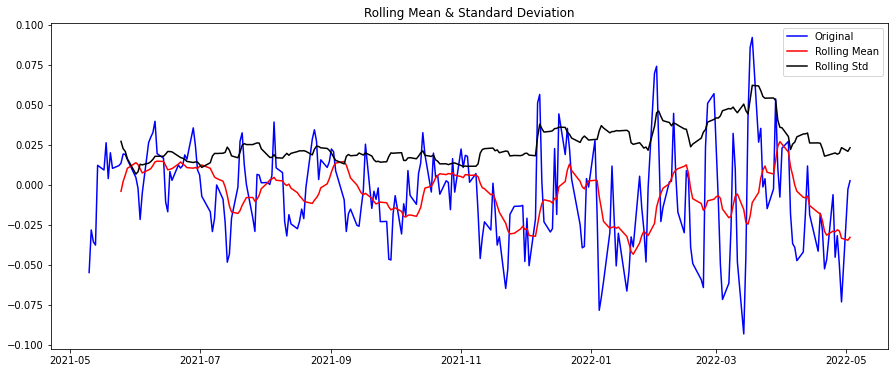

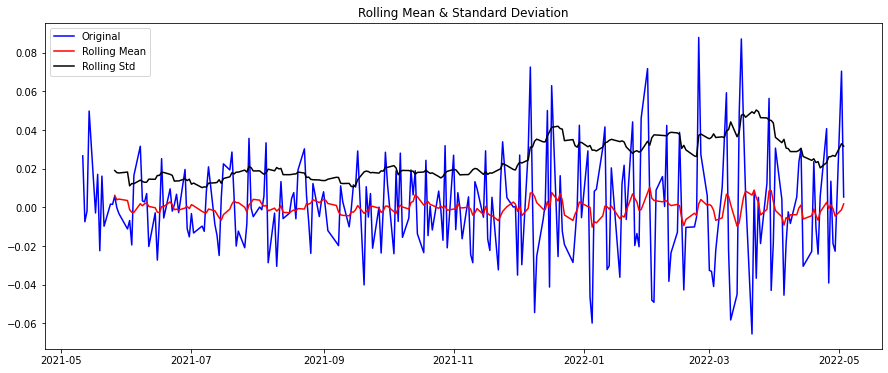

In [166]:
plot_rolling_statistics(ts_log_moving_avg_ARKG)
plot_rolling_statistics(ts_log_moving_avg_diff_ARKG)

In [167]:
augmented_dickey_fuller_test(ts_log_moving_avg_diff_ARKG)

Results of Dickey-Fuller Test:
Test Statistic                -1.028548e+01
p-value                        3.684519e-18
#Lags Used                     5.000000e+00
Number of Observations Used    2.420000e+02
Critical Value (1%)           -3.457664e+00
Critical Value (5%)           -2.873559e+00
Critical Value (10%)          -2.573175e+00
dtype: float64


- 매우 stationary해 보입니다!

##### 4) seasonal_decompose

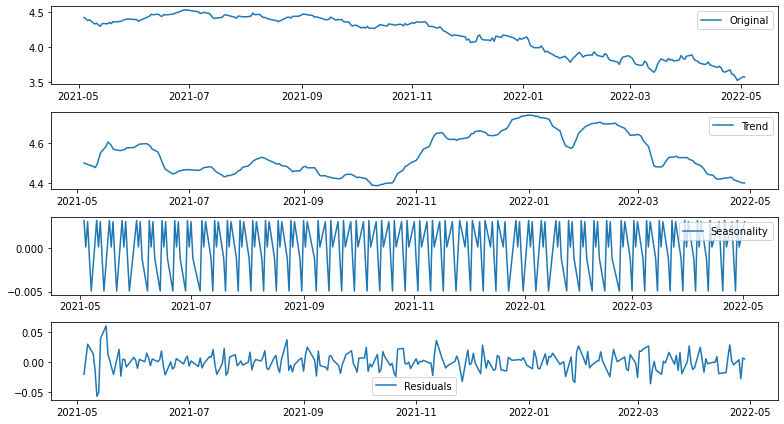

In [192]:
decomposition_ARKG = seasonal_decompose(ts_log_ARKG, model = 'multiplicative', period = 5) # model = 'additive' / 'multiplicative' 선택 가능
trend_ARKG = decomposition.trend
seasonal_ARKG = decomposition.seasonal
residual_ARKG = decomposition.resid

plt.rcParams["figure.figsize"] = (11,6)
plt.subplot(411)
plt.plot(ts_log_ARKG, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend_ARKG, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal_ARKG,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual_ARKG, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

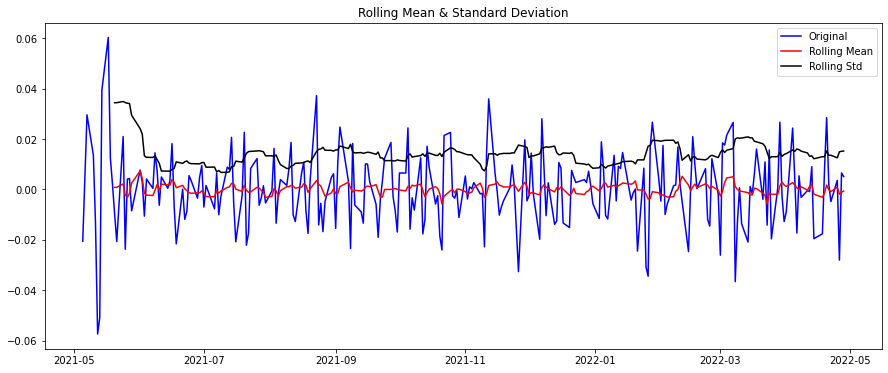

In [193]:
plot_rolling_statistics(residual_ARKG)

In [194]:
residual_ARKG.dropna(inplace=True)
augmented_dickey_fuller_test(residual_ARKG)

Results of Dickey-Fuller Test:
Test Statistic                  -5.393208
p-value                          0.000004
#Lags Used                      15.000000
Number of Observations Used    233.000000
Critical Value (1%)             -3.458731
Critical Value (5%)             -2.874026
Critical Value (10%)            -2.573424
dtype: float64


## 3.5 ARIMA 모델 활용

#### 3.5.1 ARIMA 모델 모수 구하기

- 마찬가지로 ts_log로만 진행합니다.

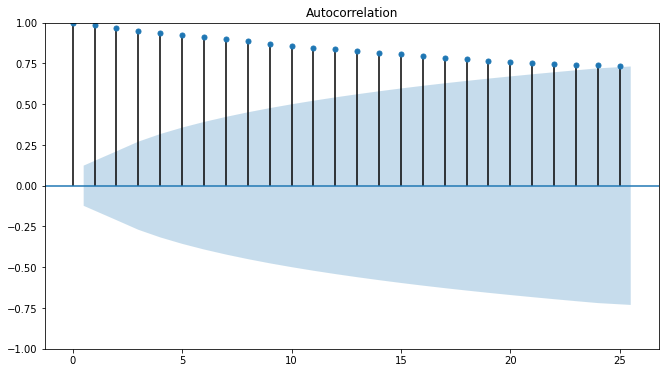

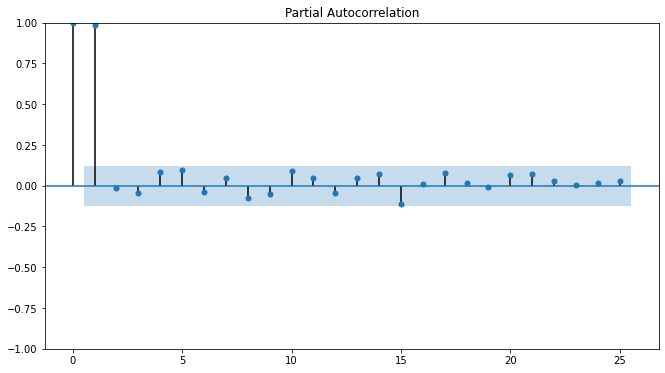

In [196]:
plot_acf(ts_log_ARKG)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log_ARKG)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

- 이렇게 보니 매우 상관관계가 강한 시계열 데이터입니다...

- p 값은 임의로 설정하고 q는 1입니다.

Results of Dickey-Fuller Test:
Test Statistic                -1.035620e+01
p-value                        2.462956e-18
#Lags Used                     2.000000e+00
Number of Observations Used    2.490000e+02
Critical Value (1%)           -3.456888e+00
Critical Value (5%)           -2.873219e+00
Critical Value (10%)          -2.572994e+00
dtype: float64


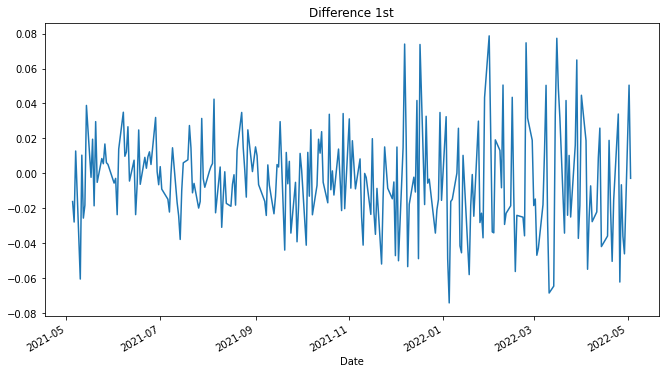

In [197]:
# 1차 차분 구하기
diff_1_ARKG = ts_log_ARKG.diff(periods=1).iloc[1:]
diff_1_ARKG.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1_ARKG)

- 충분하니 그만하겠습니다!
- d = 1

#### 3.5.2 ARIMA 모델 훈련

##### 1) log변환을 이용한 ARIMA 모델학습

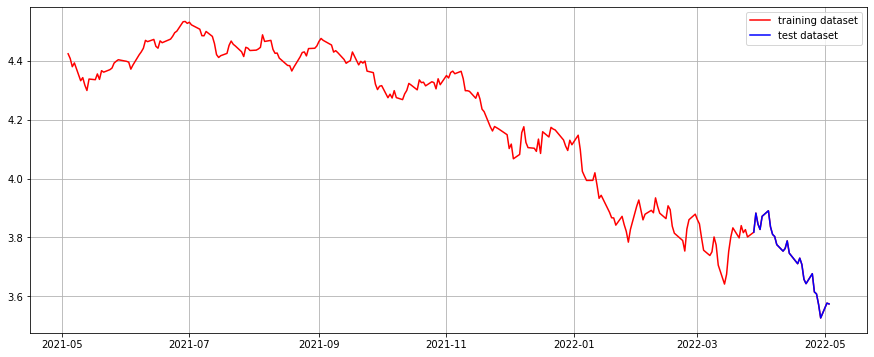

In [198]:
train_data_ARKG, test_data_ARKG = ts_log_ARKG[:int(len(ts_log)*0.9)], ts_log_ARKG[int(len(ts_log)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log_ARKG, c='r', label='training dataset')
plt.plot(test_data_ARKG, c='b', label='test dataset')
plt.legend()

In [230]:
model_ARKG = ARIMA(train_data_ARKG, order=(0, 1, 1))  
fitted_ARKG = model_ARKG.fit() 

print(fitted_ARKG.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  227
Model:                 ARIMA(0, 1, 1)   Log Likelihood                 494.089
Date:                Thu, 05 May 2022   AIC                           -984.177
Time:                        09:12:34   BIC                           -977.336
Sample:                             0   HQIC                          -981.416
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.0578      0.056      1.026      0.305      -0.053       0.168
sigma2         0.0007   6.48e-05     11.392      0.000       0.001       0.001
Ljung-Box (L1) (Q):                   0.03   Jarque-

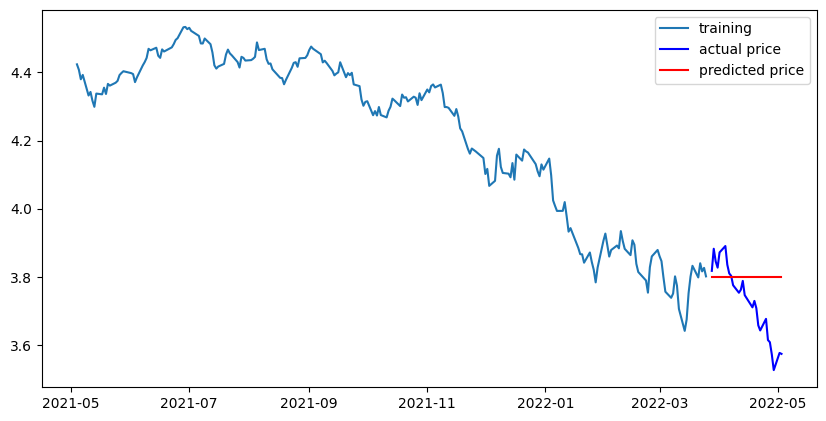

In [231]:
# Forecast : 결과가 fc_log_ARKG에 담깁니다. 
fc_log_ARKG = fitted_ARKG.forecast(len(test_data_ARKG), alpha=0.05)  # 95% conf
fc_log_ARKG = np.array(fc_log_ARKG)
# Make as pandas series
fc_log_ARKG_series = pd.Series(fc_log_ARKG, index=test_data_ARKG.index)   # 예측결과

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data_ARKG, label='training')
plt.plot(test_data_ARKG, c='b', label='actual price')
plt.plot(fc_log_ARKG_series, c='r',label='predicted price')
plt.legend()
plt.show()

#### 3.5.3 ARIMA 모델 결과 해석

In [232]:
mse = mean_squared_error(np.exp(test_data_ARKG), np.exp(fc_log_ARKG))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data_ARKG), np.exp(fc_log_ARKG))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data_ARKG), np.exp(fc_log_ARKG)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc_log_ARKG) - np.exp(test_data_ARKG))/np.abs(np.exp(test_data_ARKG)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  26.45310286454058
MAE:  4.11233263733096
RMSE:  5.14325800096987
MAPE: 10.60%


- 15부터 1까지 홀수로 내려오며 p값을 수정했습니다. 제일 좋은 결과는 p 값이 13일 때 10.33%로 약 10~11% 사이에서 움직입니다. 여전히 평균값에 수렴하려는 성질이 강한 것 같다는 생각에는 변함이 없습니다.


# 4. Auto-ARIMA

- ARIMA의 복잡한 과정을 줄여주는 친절한 Auto-ARIMA입니다.
- ARIMA와 큰 차이는 없겠지만 시도해봅니다.

## 4.1 주가 예측(ARKQ)

#### 4.1.1 데이터 확인

- DBA : Invesco DB Agriculture Fund(Invesco의 농산물 ETF)
- ARKQ : ARK Autonomous Technology & Robotics ETF(Ark의 자율주행, 로봇 등 미래기술 ETF)


- 남은 데이터는 2개입니다 이번엔 ARKQ를 사용하겠습니다.

In [354]:
# df_ARKQ 데이터에서 종가('Close')만 따로 series 형태로 분리한다. 
print(type(df_ARKQ))
print(df_ARKQ.head(5))

ts_ARKQ = df_ARKQ['Close']
print(type(ts_ARKQ))
print(ts_ARKQ.head(5))

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-04  81.070000  81.366997  79.510002  80.860001  80.223488   811300
2021-05-05  81.300003  81.489998  80.029999  80.190002  79.558762   514000
2021-05-06  80.000000  80.317001  78.830002  79.940002  79.310730   897500
2021-05-07  80.620003  81.809998  80.080002  80.709999  80.074669   829500
2021-05-10  80.050003  80.059998  77.410004  77.500000  76.889938  1025100
<class 'pandas.core.series.Series'>
Date
2021-05-04    80.860001
2021-05-05    80.190002
2021-05-06    79.940002
2021-05-07    80.709999
2021-05-10    77.500000
Name: Close, dtype: float64


#### 4.1.2 시각화

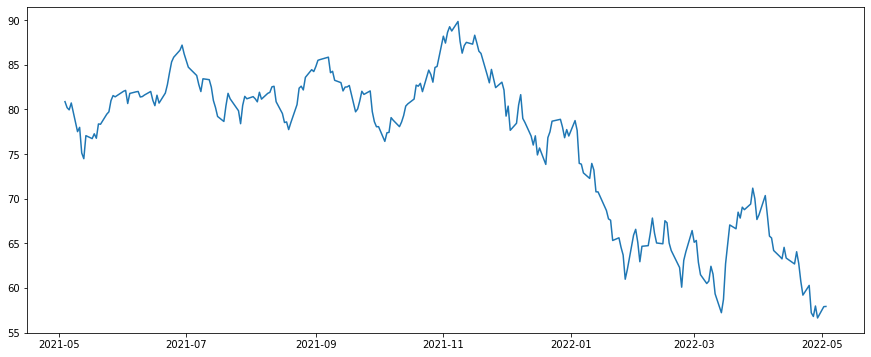

In [355]:
rcParams['figure.figsize'] = 15, 6 
plt.plot(ts_ARKQ)

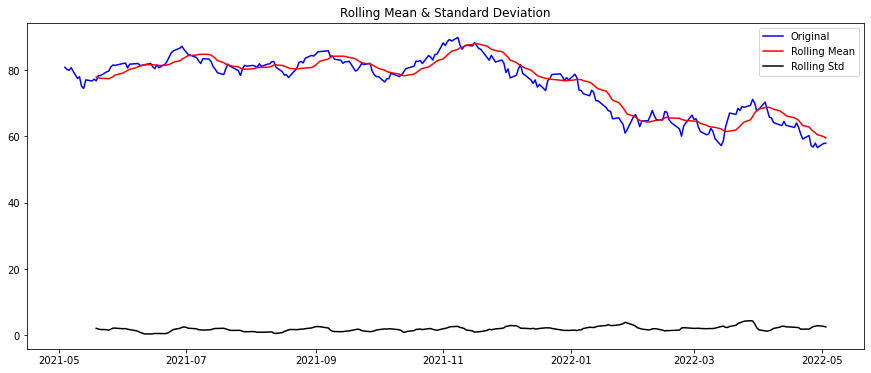

In [356]:
plot_rolling_statistics(ts_ARKQ, window=12)

- 21년 05월부터 21년 11월까지 횡보하다가 완만한 우하향 추세를 보여줍니다.

In [399]:
augmented_dickey_fuller_test(ts_ARKQ)

Results of Dickey-Fuller Test:
Test Statistic                  -0.438822
p-value                          0.903412
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 물론 stationary할 수 없습니다. p-value값이 1에 수렴할 정도입니다.

#### 4.1.3 Stationary한 시계열로 가공

1) log함수 변환

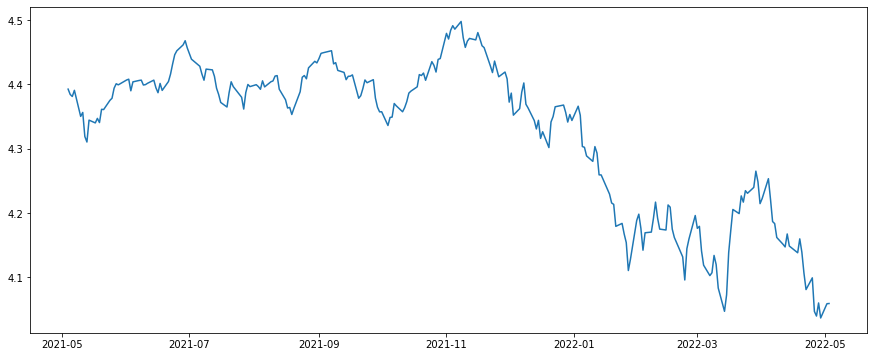

In [358]:
ts_log_ARKQ = np.log(ts_ARKQ)
plt.plot(ts_log_ARKQ)

In [359]:
augmented_dickey_fuller_test(ts_log_ARKQ)

Results of Dickey-Fuller Test:
Test Statistic                  -0.359045
p-value                          0.916715
#Lags Used                       0.000000
Number of Observations Used    252.000000
Critical Value (1%)             -3.456569
Critical Value (5%)             -2.873079
Critical Value (10%)            -2.572919
dtype: float64


- 아직도 p-value가 매우 높지만, Auto-ARIMA라는 모델을 사용한다는데 의의를 둡니다.

## 4.2 Auto-ARIMA 모델 활용

### 4.2.1 데이터셋 분류

- log 데이터를 train, test로 변환합니다.

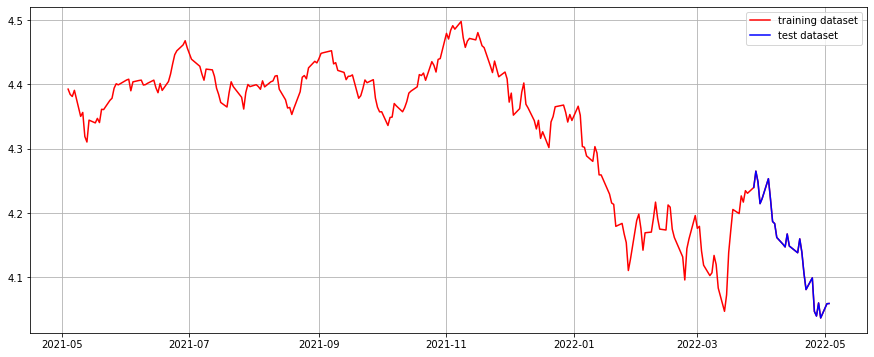

In [360]:
train_data_ARKQ, test_data_ARKQ = ts_log_ARKQ[:int(len(ts_log_ARKQ)*0.9)], ts_log_ARKQ[int(len(ts_log_ARKQ)*0.9):]
plt.figure(figsize=(15,6))
plt.grid(True)
plt.plot(ts_log_ARKQ, c='r', label='training dataset')
plt.plot(test_data_ARKQ, c='b', label='test dataset')
plt.legend()

### 4.2.2 모델 훈련

- 귀찮게 모수 구하는 과정도 없습니다.  
데이터 넣고 훈련하고 끝입니다.

In [361]:
auto_model = pm.auto_arima (train_data_ARKQ, d = 1, seasonal = False, trace = True)
auto_model.fit(train_data_ARKQ)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-1153.234, Time=0.73 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-1155.423, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-1154.999, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-1154.920, Time=0.07 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-1157.088, Time=0.06 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-1153.003, Time=0.35 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.395 seconds


ARIMA(order=(0, 1, 0), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

- 아래에서 2번째 줄을보면 ARIMA(order=(0, 1, 0)가 나옵니다.  
순서대로 p, d, q 값입니다. 그대로 진행합니다.

In [362]:
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  227
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 579.544
Date:                Thu, 05 May 2022   AIC                          -1157.088
Time:                        09:51:42   BIC                          -1153.667
Sample:                             0   HQIC                         -1155.708
                                - 227                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0003   2.84e-05     12.216      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   1.60   Jarque-Bera (JB):                 5.80
Prob(Q):                              0.21   Pr

- Model: SARIMAX(0, 1, 0)를 참고해보면 알아서 넣고 돌렸다는 것을 알 수 있습니다.

### 4.2.3 예측 확인

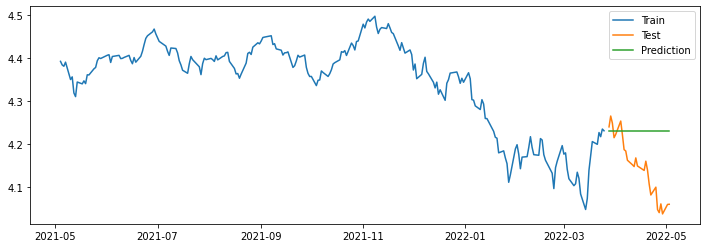

In [363]:
# 테스트 데이터 개수만큼 예측
y_predict = auto_model.predict(n_periods=len(test_data_ARKQ)) 
y_predict = pd.DataFrame(y_predict,index = test_data_ARKQ.index,columns=['Prediction'])

# 그래프
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data_ARKQ, label='Train')        # 훈련 데이터
plt.plot(test_data_ARKQ, label='Test')          # 테스트 데이터
plt.plot(y_predict, label='Prediction')  # 예측 데이터
plt.legend()
plt.show()

- 예측 결과가 이상합니다. 열심히 구글링합니다...
- 결론은 Auto-ARIMA이 찾은 ARIMA(0,1,0) 모형은 1차 differencing 결과 백색 잡음으로 판단되는 것 같습니다  
(seagate의 residual을 ARIMA 모형으로 돌린 것과 같은 결과)
  결국 상수항이 없는 임의 보행 모형을 따르므로 예측할 때 innovation term인 기댓값이 0이어서 예측치들은 가장 마지막 관측치로 동일하다는 내용입니다.

- 어렵습니다... 결과적으로 시계열 데이터에서 어떤 구조를 찾아보기 어렵기 때문에 가장 마지막 관측치가 가장 좋은 예측치라는 설명입니다.

- 해결책은 관측치를 한 번 움직일 때마다 업데이트해 주는 방법이 있다고 합니다. 이를 빌려와 사용합니다.

In [364]:
def forecast_one_step():
    fc, conf_int = auto_model.predict(n_periods=1 
        , return_conf_int=True)              
    return (
        fc.tolist()[0],
        np.asarray(conf_int).tolist()[0]
    )

In [365]:
forecasts = []
y_pred = []
pred_upper = []
pred_lower = []

for new_ob in test_data_ARKQ:
    fc, conf = forecast_one_step()
    y_pred.append(fc)
    pred_upper.append(conf[1])
    pred_lower.append(conf[0])

    ## 모형 업데이트
    auto_model.update(new_ob)

In [366]:
pd.DataFrame({"test": test_data_ARKQ, "pred": y_pred}).tail(10)

,test,pred
Date,,
2022-04-20,4.138999,4.159664
2022-04-21,4.106438,4.138999
2022-04-22,4.080753,4.106438
2022-04-25,4.099000,4.080753
2022-04-26,4.046729,4.099000
2022-04-27,4.039536,4.046729
2022-04-28,4.059926,4.039536
2022-04-29,4.036539,4.059926
2022-05-02,4.058717,4.036539


- 테이블을 보면 알겠지만 전일 종가가 다음날의 예측값입니다.

In [367]:
print(auto_model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                  253
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 639.136
Date:                Thu, 05 May 2022   AIC                          -1276.271
Time:                        09:51:44   BIC                          -1272.742
Sample:                             0   HQIC                         -1274.851
                                - 253                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
sigma2         0.0004   2.99e-05     12.271      0.000       0.000       0.000
Ljung-Box (L1) (Q):                   0.91   Jarque-Bera (JB):                 2.66
Prob(Q):                              0.34   Pr

In [368]:
fig, axes = plt.subplots(1, 1, figsize=(12, 4))
plt.plot(train_data_ARKQ, label='Train')        
plt.plot(test_data_ARKQ, label='Test')          
plt.plot(y_pred, label='Prediction')   
plt.legend()
plt.show()

ValueError: ignored

- 예측값을 시각화하는 과정에서 y_pred에는 Date 칼럼이 없습니다. error가 발생하기 때문에 기존 y_predict 값에 대체합니다.

In [369]:
print(y_pred)
new_y_pred = y_predict
new_y_pred['Prediction'] = y_pred
print(new_y_pred.head(5))

[4.230622209601326, 4.239742750500159, 4.265071353209451, 4.248495242049359, 4.214495222471686, 4.222297955862375, 4.253340570179187, 4.22141760075211, 4.186619883923976, 4.183423184320736, 4.161847466481188, 4.151197342323779, 4.1470951276076295, 4.167285202118083, 4.148517041110494, 4.13804241748782, 4.15966407518115, 4.138999234640122, 4.106437809909484, 4.0807525918078875, 4.099000357169045, 4.046728690800975, 4.0395363081214715, 4.059925652601943, 4.036538897784198, 4.058717419121264]
            Prediction
Date                  
2022-03-28    4.230622
2022-03-29    4.239743
2022-03-30    4.265071
2022-03-31    4.248495
2022-04-01    4.214495


- 다시 시각화합니다.

#### 3.5.3 ARIMA 모델 결과 해석

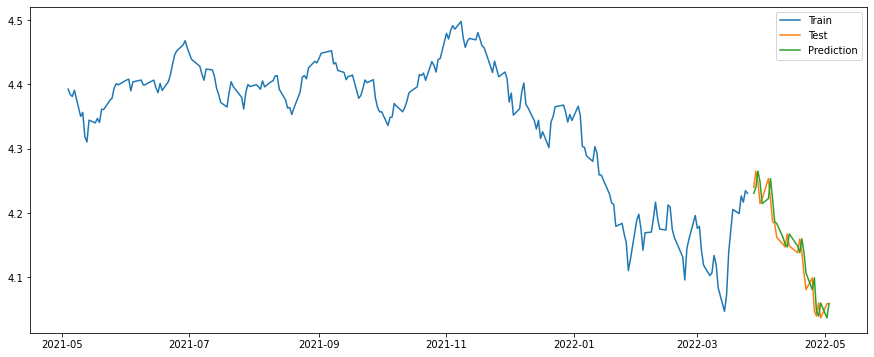

In [400]:
fig, axes = plt.subplots(1, 1, figsize=(15, 6))
plt.plot(train_data_ARKQ, label='Train')       
plt.plot(test_data_ARKQ, label='Test')         
plt.plot(new_y_pred, label='Prediction')  
plt.legend()
plt.show()

- 잘 예측한 것 같아보이지만, 결국 random walk를 따르기 때문에 매번 전일 종가를 업데이트해줘야 합니다.   
Auto-ARIMA라고는 하지만 ARIMA모델을 따릅니다.   
명백한 패턴이 있는 시계열 데이터를 잘 예측에 적합하다는 생각에 변함이 없습니다. 

# 5. Prophet

- ARIMA의 복잡한 과정을 줄여주는 친절한 Auto-ARIMA입니다.
- ARIMA와 큰 차이는 없겠지만 시도해봅니다.

## 5.1 주가 예측(ARKQ)

#### 5.1.1 데이터 확인

- DBA : Invesco DB Agriculture Fund(Invesco의 농산물 ETF)

In [427]:
# df_DBA 데이터에서 종가('Close')만 따로 series 형태로 나눠준다. 
print(type(df_DBA))
print(df_DBA.head(5))
pr_DBA = df_DBA['Close']
pr_DBA = pr_DBA.reset_index()
pr_DBA.columns = ['ds', 'y']
print(pr_DBA.info()) 

<class 'pandas.core.frame.DataFrame'>
                 Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2021-05-04  18.430000  18.559999  18.379999  18.490000  18.490000  1908800
2021-05-05  18.639999  18.940001  18.549999  18.920000  18.920000  2055500
2021-05-06  19.000000  19.230000  18.920000  19.209999  19.209999  2428200
2021-05-07  19.250000  19.360001  19.070000  19.330000  19.330000  3591100
2021-05-10  19.250000  19.250000  18.980000  18.980000  18.980000  3319400
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 253 entries, 0 to 252
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      253 non-null    datetime64[ns]
 1   y       253 non-null    float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 4.1 KB
None


- 여기서 애먹었는데 Prophet은 colums로 'ds'와 'y'만 받습니다.  
ds에는 date를 y에는 close를 넣어줍니다.
  

#### 5.1.2 시각화

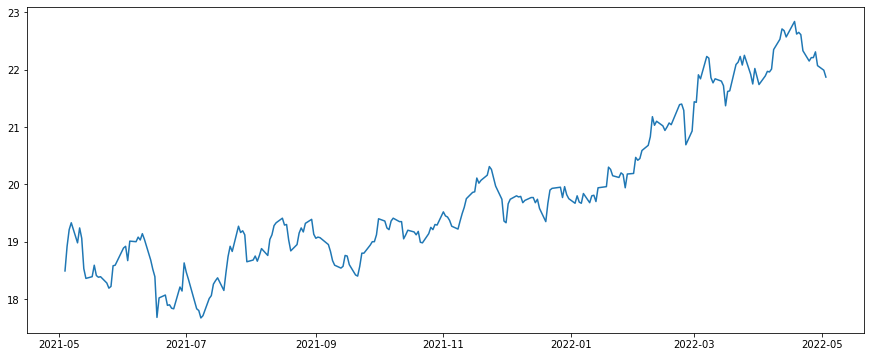

In [428]:
rcParams['figure.figsize'] = 15, 6 
plt.plot(df_DBA['Close'])

- 농산물ETF는 꾸준한 21년 7월을 기점으로 우상향 형태를 보입니다.

## 5.2 Prophet 모델 활용

### 5.2.1 모델 적용

- Auto-ARIMA보다 더 쉽습니다.
- trend, seasonality 파라미터 값들만 수정합니다.

In [429]:
prophet = Prophet(seasonality_mode='multiplicative', 
                  yearly_seasonality=True,
                  weekly_seasonality=True, daily_seasonality=True,
                  changepoint_prior_scale=0.5)

In [430]:
prophet.fit(pr_DBA)

In [431]:
future_data = prophet.make_future_dataframe(periods=5, freq='d')
forecast_data = prophet.predict(future_data)

In [432]:
forecast_data.tail(5)

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,daily,daily_lower,daily_upper,multiplicative_terms,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
253,2022-05-04,3.154088,21.367809,21.806542,3.154088,3.154088,4.870969,4.870969,4.870969,5.846812,...,0.251513,0.251513,0.251513,0.724330,0.724330,0.724330,0.0,0.0,0.0,21.595449
254,2022-05-05,3.148274,21.196117,21.636621,3.148274,3.148274,4.870969,4.870969,4.870969,5.806245,...,0.242334,0.242334,0.242334,0.692942,0.692942,0.692942,0.0,0.0,0.0,21.427925
255,2022-05-06,3.142460,21.035687,21.533789,3.142460,3.143323,4.870969,4.870969,4.870969,5.770965,...,0.240323,0.240323,0.240323,0.659673,0.659673,0.659673,0.0,0.0,0.0,21.277489
256,2022-05-07,3.136647,18.243108,18.711011,3.131427,3.141931,4.870969,4.870969,4.870969,4.886879,...,-0.608871,-0.608871,-0.608871,0.624782,0.624782,0.624782,0.0,0.0,0.0,18.465060
257,2022-05-08,3.130833,18.030398,18.594766,3.118122,3.142399,4.870969,4.870969,4.870969,4.850632,...,-0.608871,-0.608871,-0.608871,0.588534,0.588534,0.588534,0.0,0.0,0.0,18.317350


In [433]:
forecast_data[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)

,ds,yhat,yhat_lower,yhat_upper
253,2022-05-04,21.595449,21.367809,21.806542
254,2022-05-05,21.427925,21.196117,21.636621
255,2022-05-06,21.277489,21.035687,21.533789
256,2022-05-07,18.465060,18.243108,18.711011
257,2022-05-08,18.317350,18.030398,18.594766


- components를 시각화할 수 있습니다.

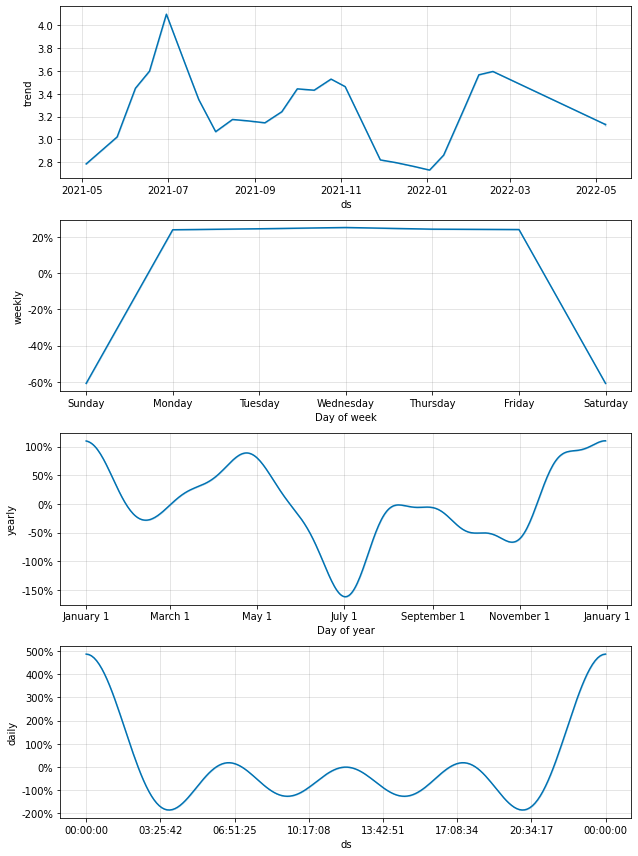

In [434]:
fig2 = prophet.plot_components(forecast_data)

- trend, seasonality를 보기 쉽게 표현합니다.
- 특히, seasonality는 년, 주, 일 형태로 확인이 가능합니다.

In [435]:
m = Prophet()
m.fit(pr_DBA)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


- 향후 60일의 주가를 예측해줍니다.

### 5.2.2 결과 확인

- periods 값을 60일로 설정하고, freq를 day를 의미하는 'D'값을 설정해서 결과를 확인합니다.

In [436]:
future = m.make_future_dataframe(periods=60, freq= 'D')
forecast = m.predict(future)

In [425]:
print(forecast.head(5))

          ds      trend  yhat_lower  yhat_upper  trend_lower  trend_upper  \
0 2021-05-04  18.776750   18.440133   19.234675    18.776750    18.776750   
1 2021-05-05  18.766293   18.452873   19.283131    18.766293    18.766293   
2 2021-05-06  18.755836   18.453993   19.195377    18.755836    18.755836   
3 2021-05-07  18.745379   18.404336   19.203210    18.745379    18.745379   
4 2021-05-10  18.714007   18.381595   19.173300    18.714007    18.714007   

   additive_terms  additive_terms_lower  additive_terms_upper    weekly  \
0        0.061260              0.061260              0.061260  0.061260   
1        0.100041              0.100041              0.100041  0.100041   
2        0.062553              0.062553              0.062553  0.062553   
3        0.054087              0.054087              0.054087  0.054087   
4        0.053547              0.053547              0.053547  0.053547   

   weekly_lower  weekly_upper  multiplicative_terms  \
0      0.061260      0.061260  

- 시각화합니다.

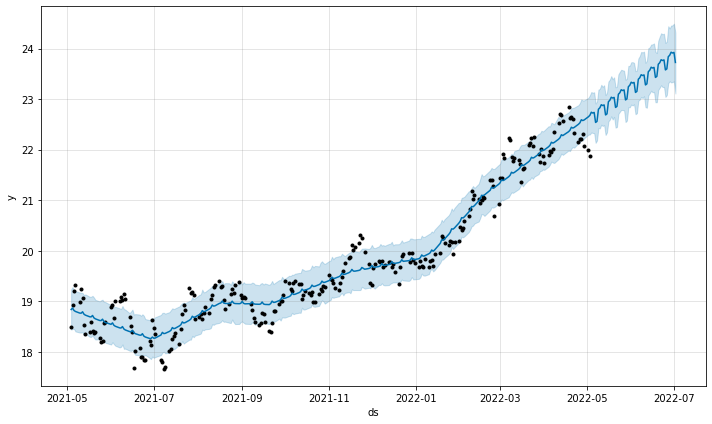

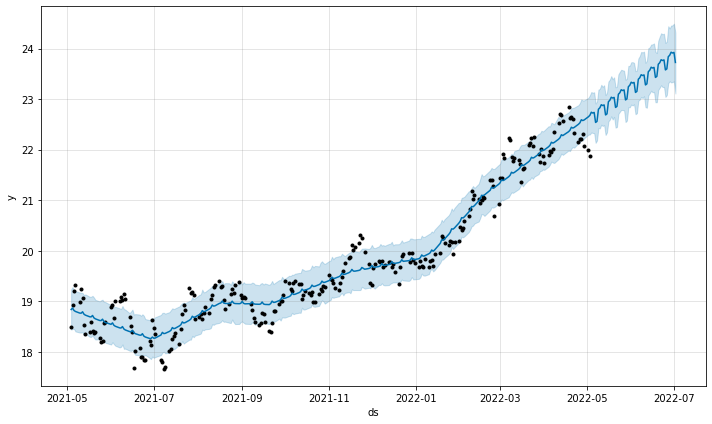

In [426]:
m.plot(forecast)

- 검은색 점들이 실제 종가 값이고, 5월 마지막 점을 기점으로 향후 데이터를 예측한 부분을 보여주고 있다.

  
  - 사실 components 시각화를 확인하며 파라미터값을 조절해야 하는데 prophet에 대한 지식이 없으므로 추후 더 배우면서 해봐야겠습니다. 이번에는 시계열 분석을 위한 모델에은 Prophet도 있다는 정도로 생각하면 좋을 것 같습니다.

# 6. 회고

- 하나를 배우면 열개의 배울게 또 생긴다...
- ARIMA는 trend하고 seasonality한 시계열의 분석을 잘할 것 같다.
- 힘들게 고생한 기억이 오래 남지만 Auto가 붙은걸 자주 활용하자
- Prophet도 있으니 이것도 공부하자
- 시계열 데이터 분석에는 깊은 통계적 지식이 필요하다. 

# References


- 아래의 페이지에서 많은 도움을 받았습니다.

- https://otexts.com/fppkr/index.html  
- https://ysyblog.tistory.com/213  
- https://yoongaemii.github.io/seasonal_decomposition/  
- https://hyperconnect.github.io/2020/03/09/prophet-package.html
